In [1]:
import numpy as np
import os
# import PIL
# import PIL.Image
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
import tensorflow_datasets as tfds
from functools import partial
import pathlib # is it used?
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

In [4]:
def plotImage(image, cmap=None, title=None):
    plt.figure()
    if cmap != None:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    if title != None:
        plt.title(title)
    plt.show()

In [5]:
def visualize(original, augmented):
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.show()

In [6]:
def predictionsToText(pred, sep=None):
    txt = ""
#     print(pred)
    for i in pred:
#         print(i)
        txt = f"{txt}{i:.4f} "
    txt = txt.strip()
    if sep != None:
        txt = txt.replace(" ", sep)
    return txt

In [7]:
batch_size = 32
# batch_size = 20
img_height = 740
img_width = 596
slice_size = 60
learning_rate=1e-5
epochs = 700
drop_rate = 0.33

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def load_labels(data):
    file_name = tf.strings.split(data, sep="/")[-1]
    label1 = tf.strings.split(file_name, sep="_")[0]
    label2 = tf.strings.split(file_name, sep="_")[1]
    label3 = tf.strings.split(file_name, sep="_")[2]
    label4 = tf.strings.split(file_name, sep="_")[3]
    label5 = tf.strings.split(file_name, sep="_")[4]
    label6 = tf.strings.split(file_name, sep="_")[5]
    out1 = 1 if label1 == '1' else 0
    out2 = 1 if label2 == '1' else 0
    out3 = 1 if label3 == '1' else 0
    out4 = 1 if label4 == '1' else 0
    out5 = 1 if label5 == '1' else 0
    out6 = 1 if label6 == '1' else 0
    outa0 = 1 if out1 + out2 + out3 == 0 else 0 #no masks present (Carlefts)
    outa1 = 1 if out1 + out2 + out3 == 1 else 0 #present 1 mask
    outa2 = 1 if out1 + out2 + out3 == 2 else 0 #present 2 masks
    outa3 = 1 if out1 + out2 + out3 == 3 else 0 #present 3 masks
    
    outb0 = 1 if out4 + out5 + out6 == 0 else 0
    outb1 = 1 if out4 + out5 + out6 == 1 else 0
    outb2 = 1 if out4 + out5 + out6 == 2 else 0
    outb3 = 1 if out4 + out5 + out6 == 3 else 0
    
    outa0 = tf.cast(outa0, dtype=tf.float32) #converting values into float
    outa1 = tf.cast(outa1, dtype=tf.float32)
    outa2 = tf.cast(outa2, dtype=tf.float32)
    outa3 = tf.cast(outa3, dtype=tf.float32)
    outb0 = tf.cast(outb0, dtype=tf.float32)
    outb1 = tf.cast(outb1, dtype=tf.float32)
    outb2 = tf.cast(outb2, dtype=tf.float32)
    outb3 = tf.cast(outb3, dtype=tf.float32)
#     out6 = tf.cast(out6, dtype=tf.float32)

    image = tf.io.read_file(data)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    return (image/255., ([outa0, outa1, outa2, outa3], [outb0, outb1, outb2, outb3]))

In [10]:
def Augmentation(data, seed):
    paddings = tf.constant([[20, 20], [5, 5], [0, 0]])
#     a = [1., 0., 0., 0.]
#     zero = np.round(a, 0)
    
    file_name = tf.strings.split(data, sep="\\")[-1]
    label1 = tf.strings.split(file_name, sep="_")[0]
    label2 = tf.strings.split(file_name, sep="_")[1]
    label3 = tf.strings.split(file_name, sep="_")[2]
    label4 = tf.strings.split(file_name, sep="_")[3]
    label5 = tf.strings.split(file_name, sep="_")[4]
    label6 = tf.strings.split(file_name, sep="_")[5]
    out1 = 1 if label1 == '1' else 0
    out2 = 1 if label2 == '1' else 0
    out3 = 1 if label3 == '1' else 0
    out4 = 1 if label4 == '1' else 0
    out5 = 1 if label5 == '1' else 0
    out6 = 1 if label6 == '1' else 0
    outa0 = 1 if out1 + out2 + out3 == 0 else 0 #no masks present (Carlefts)
    outa1 = 1 if out1 + out2 + out3 == 1 else 0 #present 1 mask
    outa2 = 1 if out1 + out2 + out3 == 2 else 0 #present 2 masks
    outa3 = 1 if out1 + out2 + out3 == 3 else 0 #present 3 masks
    
    outb0 = 1 if out4 + out5 + out6 == 0 else 0
    outb1 = 1 if out4 + out5 + out6 == 1 else 0
    outb2 = 1 if out4 + out5 + out6 == 2 else 0
    outb3 = 1 if out4 + out5 + out6 == 3 else 0
    
    outa0 = tf.cast(outa0, dtype=tf.float32) #converting values into float
    outa1 = tf.cast(outa1, dtype=tf.float32)
    outa2 = tf.cast(outa2, dtype=tf.float32)
    outa3 = tf.cast(outa3, dtype=tf.float32)
    outb0 = tf.cast(outb0, dtype=tf.float32)
    outb1 = tf.cast(outb1, dtype=tf.float32)
    outb2 = tf.cast(outb2, dtype=tf.float32)
    outb3 = tf.cast(outb3, dtype=tf.float32)
#     out6 = tf.cast(out6, dtype=tf.float32)

    image = tf.io.read_file(data)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.
    image = tf.pad(image, paddings, mode='REFLECT')
    image = tf.image.stateless_random_crop(image, [740, 60, 3], seed=seed)
#     image = tfa.image.gaussian_filter2d(
#         image
#         filter_shape = (3, 3),
#         sigma = 1.0,
#         padding = 'REFLECT',
#         constant_values = 0,
#     )
# Check whether labels should be mirrored
    return (image, ([outa0, outa1, outa2, outa3], [outb0, outb1, outb2, outb3]))

In [50]:
# for dataset in datasets:
    it1 = iter(ds_training)
    print(it1)
    
    augmented = []
    y1_labels = []
    y2_labels = []
    
#     for i in range(4):
#         print(next(it1))
    
    for i in np.arange(13):
        img, labels = next(it1)
    #     batch_names = next(it2)
        y1, y2 = labels
        b = y1.numpy().shape[0]

        for i in np.arange(b):
            if not ((np.array_equal(y1[i].numpy(), zero)) or (np.array_equal(y2[i].numpy(), zero))): #if image is contains smth
                padded = tf.pad(img[i], paddings, mode='REFLECT')
    #             visualize(img[i], padded)
    #             print(y1[i].numpy(), y2[i].numpy())
                padded_img1 = tf.image.random_crop(padded, [740, 60, 3], seed=43)
                padded_img2 = tf.image.random_crop(padded, [740, 60, 3], seed=21)
                padded_img3 = tf.image.random_crop(padded, [740, 60, 3], seed=15)
    #             visualize(padded_img3, padded)
                augmented.append(padded_img1)
                augmented.append(padded_img2)
                augmented.append(padded_img3)
                y1_labels.append(y1[i])
                y1_labels.append(y1[i])
                y1_labels.append(y1[i])
                y2_labels.append(y2[i])
                y2_labels.append(y2[i])
                y2_labels.append(y2[i])
    #             train_ds = tf.data.Dataset.from_tensors(padded)
    augmented = np.array(augmented)
    y1_labels = np.array(y1_labels)  
    y2_labels = np.array(y2_labels)
    print(augmented.shape)
    print(y1_labels.shape)
    
    
#     locals()['name'] = str(dataset)+"_aug"
#     name = tf.data.Dataset.from_tensor_slices((augmented, y1_labels, y2_labels))
#     print("zzzzzzzz")
#     print(locals()[dataset + "_aug"])

#     train_ds = tf.data.Dataset.from_tensor_slices((augmented, y1_labels, y2_labels))

    train_ds = (
        train_ds
        .shuffle(1000)
        .map(augment, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
        )
    print(train_ds)
    print("____________________")
    print(ds_training)
    ds_training = tf.data.Dataset.zip((ds_training, train_ds))
    print(ds_training)

IndentationError: unexpected indent (Temp/ipykernel_27064/3242166452.py, line 2)

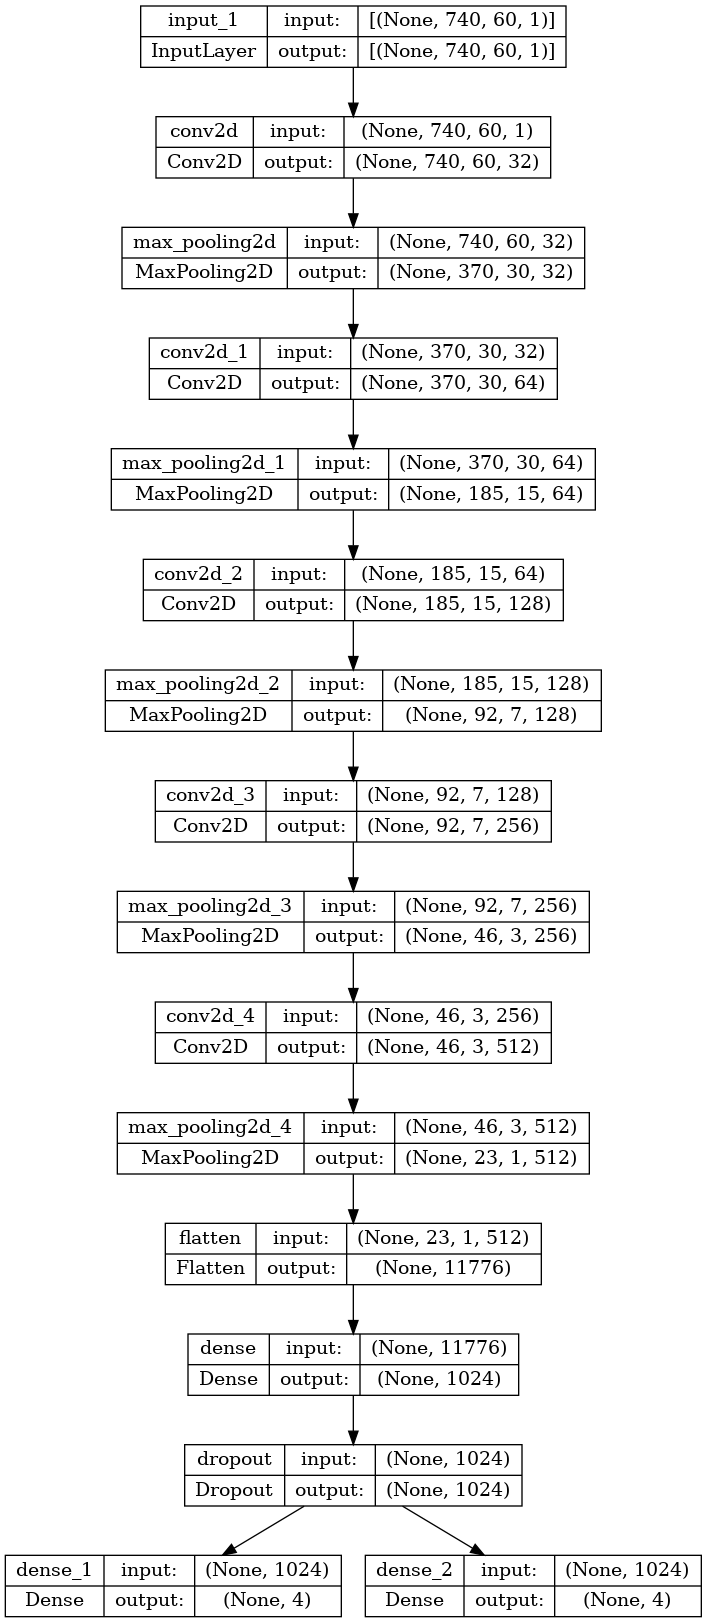

In [10]:
input_layer = tf.keras.layers.Input(shape=(740, slice_size, 1,))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(input_layer)
# Try valid padding
x = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(input_layer)#(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)

# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(drop_rate)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(drop_rate)(x)

#make 6 layers here(x)
x1 = tf.keras.layers.Dense(4, activation='softmax')(x)
x2 = tf.keras.layers.Dense(4, activation='softmax')(x)
# x3 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x4 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x5 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# x6 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=[x1, x2])
# model = tf.keras.Model(inputs=input_layer, outputs=[x1, x2, x3, x4, x5, x6])

dot_img_file = '/tf/train_py/Architecture_plots/beseline_model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_layer_names=True, show_shapes=True)


In [11]:
tf.random.set_seed(43)
# counter = tf.data.experimental.Counter()
# seeds
#Augmentation
# seed_aug_0 = tf.data.Dataset.from_tensor_slices([10])
# seed_aug_0 = seed_aug_0.repeat(10000000)
# seed_aug_1 = tf.data.Dataset.from_tensor_slices([25])
# seed_aug_1 = seed_aug_1.repeat(10000000)
# seed_aug_2 = tf.data.Dataset.from_tensor_slices([59])
# seed_aug_2 = seed_aug_2.repeat(10000000)


ds_names_o = tf.data.Dataset.list_files(str('./images_split/*.png'), shuffle=False).batch(batch_size)
ds_training_ = tf.data.Dataset.list_files(str('./images_split/*.png'), shuffle=False)
# ds_training = (ds_training
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_15 = tf.data.Dataset.list_files(str('./images_split_15/*.png'), shuffle=False)
# ds_training_15 = (ds_training_15
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_30 = tf.data.Dataset.list_files(str('./images_split_30/*.png'), shuffle=False)
# ds_training_30 = (ds_training_30
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_training_45 = tf.data.Dataset.list_files(str('./images_split_45/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
ds_synth = tf.data.Dataset.list_files(str('./images_synth/*.png'), shuffle=False)
# ds_training_45 = (ds_training_45
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

ds_training = ds_training_.concatenate(ds_training_15).concatenate(ds_training_30).concatenate(ds_training_45).concatenate(ds_synth) #names
# ds_training_aug = ds_training
# Augmentation
# ds_training_aug = tf.data.Dataset.zip((ds_training, (seed_aug_0, seed_aug_0)))
# ds_training_aug_1 = tf.data.Dataset.zip((ds_training, (seed_aug_1, seed_aug_1)))
# ds_training_aug_2 = tf.data.Dataset.zip((ds_training, (seed_aug_2, seed_aug_2)))

ds_training = (ds_training
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
#Augmentation
# ds_training_aug = (ds_training_aug
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_1 = (ds_training_aug_1
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_training_aug_2 = (ds_training_aug_2
#   .shuffle(180, seed=43)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_synth = (ds_synth
#   .shuffle(180, seed=43)
#   .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )

# ds_training = ds_training.concatenate(ds_training_aug).concatenate(ds_training_aug_1).concatenate(ds_training_aug_2)
#.concatenate(ds_synth)

ds_val = tf.data.Dataset.list_files(str('./images_split_val/*.png')) #names
# ds_val_aug = ds_val
# Augmentation
# ds_val_aug = tf.data.Dataset.zip((ds_val, (seed_aug_0, seed_aug_0)))
# ds_val_aug_1 = tf.data.Dataset.zip((ds_val, (seed_aug_1, seed_aug_1)))
# ds_val_aug_2 = tf.data.Dataset.zip((ds_val, (seed_aug_2, seed_aug_2)))

ds_val = (ds_val
#   .shuffle(180, seed=3343)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)
# ds_val_aug = (ds_val_aug
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_1 = (ds_val_aug_1
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val_aug_2 = (ds_val_aug_2
# #   .shuffle(180, seed=3343)
#   .map(Augmentation, num_parallel_calls=AUTOTUNE)
#   .cache()
#   # .repeat()
#   .batch(batch_size)
#   .prefetch(AUTOTUNE)
# )
# ds_val = ds_val.concatenate(ds_val_aug).concatenate(ds_val_aug_1).concatenate(ds_val_aug_2)

ds_test = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False)
ds_test = (ds_test
  .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
  .cache()
  # .repeat()
  .batch(batch_size)
  .prefetch(AUTOTUNE)
)

ds_test_names_o = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False).batch(100)
# .batch(batch_size)
ds_test_o = tf.data.Dataset.list_files(str('./images_split_test/*.png'), shuffle=False)
ds_test_o = (ds_test_o
#   .shuffle(180, seed=43)
  .map(load_labels, num_parallel_calls=AUTOTUNE)
#   .cache()
#   .repeat()
#   .batch(batch_size)
  .batch(100)
#   .prefetch(AUTOTUNE)
)


In [12]:
# Check label values
it1 = iter(ds_test)
a = [1., 0., 0., 0.]
z = np.round(a,0)

for i in np.arange(13):
    img, labels = next(it1)
    y1, y2 = labels
    b = y1.numpy().shape[0]
#     predictions_test = model.predict(img)
#     PlotDataset(y1,y2)
    print(y1.shape)
    for elem in y1:
        if not (np.array_equal(elem, z)):
            print(((elem).numpy()))
#     for i in np.arange(b):
#         p1, p2 = predictions_test
#         current_name = batch_names[i].numpy().decode("UTF-8")
#         current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
#         current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)
#         plotImage(current_img, title=os.path.basename(current_name))

(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)
(32, 4)


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),#'adam',
  loss=[tf.losses.CategoricalCrossentropy(label_smoothing=0.1),tf.losses.CategoricalCrossentropy(label_smoothing=0.1)],
#   loss=[tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy(),tf.losses.BinaryCrossentropy()],
  # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])
  # metrics=[tf.keras.losses.mean_absolute_error, "accuracy"])

In [14]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 740, 60, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 740, 60, 32)  832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 370, 30, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 370, 30, 64)  51264       ['max_pooling2d[0][0]']      

In [15]:
history = model.fit(
  ds_training,
  validation_data=ds_val,
  epochs=500
)

Epoch 1/500
213/213 [==============================] - 27s 91ms/step - loss: 2.3761 - dense_1_loss: 1.1379 - dense_2_loss: 1.2382 - dense_1_accuracy: 0.6183 - dense_2_accuracy: 0.5254 - val_loss: 2.8186 - val_dense_1_loss: 1.6325 - val_dense_2_loss: 1.1861 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 2/500
213/213 [==============================] - 17s 80ms/step - loss: 2.4562 - dense_1_loss: 1.2391 - dense_2_loss: 1.2170 - dense_1_accuracy: 0.5057 - dense_2_accuracy: 0.5536 - val_loss: 2.6275 - val_dense_1_loss: 1.3651 - val_dense_2_loss: 1.2624 - val_dense_1_accuracy: 0.1487 - val_dense_2_accuracy: 0.5739
Epoch 3/500
213/213 [==============================] - 17s 80ms/step - loss: 2.4005 - dense_1_loss: 1.1895 - dense_2_loss: 1.2110 - dense_1_accuracy: 0.5657 - dense_2_accuracy: 0.5607 - val_loss: 2.6594 - val_dense_1_loss: 1.4683 - val_dense_2_loss: 1.1911 - val_dense_1_accuracy: 0.1418 - val_dense_2_accuracy: 0.5739
Epoch 4/500
213/213 [======================

Epoch 27/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3625 - dense_1_loss: 1.1456 - dense_2_loss: 1.2168 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5613 - val_loss: 2.4411 - val_dense_1_loss: 1.2181 - val_dense_2_loss: 1.2231 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 28/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3536 - dense_1_loss: 1.1398 - dense_2_loss: 1.2138 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.5097 - val_dense_1_loss: 1.2606 - val_dense_2_loss: 1.2491 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 29/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3206 - dense_1_loss: 1.1088 - dense_2_loss: 1.2118 - dense_1_accuracy: 0.6168 - dense_2_accuracy: 0.5328 - val_loss: 2.4970 - val_dense_1_loss: 1.2761 - val_dense_2_loss: 1.2209 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 30/500
213/213 [==================

Epoch 53/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3265 - dense_1_loss: 1.1249 - dense_2_loss: 1.2016 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.3998 - val_dense_1_loss: 1.1889 - val_dense_2_loss: 1.2109 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 54/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3217 - dense_1_loss: 1.1173 - dense_2_loss: 1.2043 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4406 - val_dense_1_loss: 1.2123 - val_dense_2_loss: 1.2283 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 55/500
213/213 [==============================] - 17s 81ms/step - loss: 2.3272 - dense_1_loss: 1.1242 - dense_2_loss: 1.2030 - dense_1_accuracy: 0.5927 - dense_2_accuracy: 0.5614 - val_loss: 2.4140 - val_dense_1_loss: 1.1970 - val_dense_2_loss: 1.2171 - val_dense_1_accuracy: 0.5918 - val_dense_2_accuracy: 0.5739
Epoch 56/500
213/213 [==================

Epoch 79/500
213/213 [==============================] - 17s 81ms/step - loss: 2.1429 - dense_1_loss: 1.0513 - dense_2_loss: 1.0916 - dense_1_accuracy: 0.6249 - dense_2_accuracy: 0.5569 - val_loss: 2.4891 - val_dense_1_loss: 1.2960 - val_dense_2_loss: 1.1931 - val_dense_1_accuracy: 0.3329 - val_dense_2_accuracy: 0.5213
Epoch 80/500
213/213 [==============================] - 17s 81ms/step - loss: 2.1766 - dense_1_loss: 1.0533 - dense_2_loss: 1.1233 - dense_1_accuracy: 0.5800 - dense_2_accuracy: 0.5631 - val_loss: 2.3408 - val_dense_1_loss: 1.2226 - val_dense_2_loss: 1.1182 - val_dense_1_accuracy: 0.4241 - val_dense_2_accuracy: 0.5799
Epoch 81/500
213/213 [==============================] - 17s 81ms/step - loss: 2.1280 - dense_1_loss: 1.0388 - dense_2_loss: 1.0892 - dense_1_accuracy: 0.5895 - dense_2_accuracy: 0.5545 - val_loss: 2.3691 - val_dense_1_loss: 1.2512 - val_dense_2_loss: 1.1179 - val_dense_1_accuracy: 0.4440 - val_dense_2_accuracy: 0.5736
Epoch 82/500
213/213 [==================

Epoch 105/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9859 - dense_1_loss: 0.9720 - dense_2_loss: 1.0139 - dense_1_accuracy: 0.6054 - dense_2_accuracy: 0.5669 - val_loss: 3.1784 - val_dense_1_loss: 1.7303 - val_dense_2_loss: 1.4481 - val_dense_1_accuracy: 0.1421 - val_dense_2_accuracy: 0.5739
Epoch 106/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9589 - dense_1_loss: 0.9559 - dense_2_loss: 1.0030 - dense_1_accuracy: 0.6026 - dense_2_accuracy: 0.5766 - val_loss: 2.2031 - val_dense_1_loss: 1.1022 - val_dense_2_loss: 1.1009 - val_dense_1_accuracy: 0.4835 - val_dense_2_accuracy: 0.5802
Epoch 107/500
213/213 [==============================] - 17s 81ms/step - loss: 1.9122 - dense_1_loss: 0.9203 - dense_2_loss: 0.9918 - dense_1_accuracy: 0.6424 - dense_2_accuracy: 0.5783 - val_loss: 2.3289 - val_dense_1_loss: 1.1732 - val_dense_2_loss: 1.1557 - val_dense_1_accuracy: 0.4494 - val_dense_2_accuracy: 0.5756
Epoch 108/500
213/213 [==============

Epoch 156/500
213/213 [==============================] - 17s 82ms/step - loss: 1.3612 - dense_1_loss: 0.6528 - dense_2_loss: 0.7084 - dense_1_accuracy: 0.8566 - dense_2_accuracy: 0.8217 - val_loss: 1.7089 - val_dense_1_loss: 0.9105 - val_dense_2_loss: 0.7985 - val_dense_1_accuracy: 0.7123 - val_dense_2_accuracy: 0.7413
Epoch 157/500
213/213 [==============================] - 17s 82ms/step - loss: 1.3161 - dense_1_loss: 0.6325 - dense_2_loss: 0.6835 - dense_1_accuracy: 0.8624 - dense_2_accuracy: 0.8289 - val_loss: 2.2351 - val_dense_1_loss: 1.2646 - val_dense_2_loss: 0.9706 - val_dense_1_accuracy: 0.5375 - val_dense_2_accuracy: 0.6728
Epoch 158/500
213/213 [==============================] - 17s 82ms/step - loss: 1.2880 - dense_1_loss: 0.6173 - dense_2_loss: 0.6706 - dense_1_accuracy: 0.8717 - dense_2_accuracy: 0.8508 - val_loss: 1.8700 - val_dense_1_loss: 1.0068 - val_dense_2_loss: 0.8633 - val_dense_1_accuracy: 0.6291 - val_dense_2_accuracy: 0.7024
Epoch 159/500
213/213 [==============

Epoch 207/500
213/213 [==============================] - 17s 82ms/step - loss: 0.9878 - dense_1_loss: 0.4904 - dense_2_loss: 0.4974 - dense_1_accuracy: 0.9442 - dense_2_accuracy: 0.9515 - val_loss: 1.6197 - val_dense_1_loss: 0.8426 - val_dense_2_loss: 0.7770 - val_dense_1_accuracy: 0.7953 - val_dense_2_accuracy: 0.8184
Epoch 208/500
213/213 [==============================] - 17s 82ms/step - loss: 0.9820 - dense_1_loss: 0.4859 - dense_2_loss: 0.4961 - dense_1_accuracy: 0.9508 - dense_2_accuracy: 0.9503 - val_loss: 1.5337 - val_dense_1_loss: 0.7811 - val_dense_2_loss: 0.7527 - val_dense_1_accuracy: 0.8090 - val_dense_2_accuracy: 0.8209
Epoch 209/500
213/213 [==============================] - 17s 82ms/step - loss: 0.9755 - dense_1_loss: 0.4869 - dense_2_loss: 0.4886 - dense_1_accuracy: 0.9489 - dense_2_accuracy: 0.9536 - val_loss: 1.6146 - val_dense_1_loss: 0.8244 - val_dense_2_loss: 0.7902 - val_dense_1_accuracy: 0.8007 - val_dense_2_accuracy: 0.8206
Epoch 210/500
213/213 [==============

Epoch 258/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7959 - dense_1_loss: 0.3996 - dense_2_loss: 0.3963 - dense_1_accuracy: 0.9956 - dense_2_accuracy: 0.9956 - val_loss: 1.3895 - val_dense_1_loss: 0.6878 - val_dense_2_loss: 0.7017 - val_dense_1_accuracy: 0.8590 - val_dense_2_accuracy: 0.8505
Epoch 259/500
213/213 [==============================] - 17s 81ms/step - loss: 0.7928 - dense_1_loss: 0.3965 - dense_2_loss: 0.3963 - dense_1_accuracy: 0.9960 - dense_2_accuracy: 0.9949 - val_loss: 1.3583 - val_dense_1_loss: 0.6814 - val_dense_2_loss: 0.6768 - val_dense_1_accuracy: 0.8559 - val_dense_2_accuracy: 0.8596
Epoch 260/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7892 - dense_1_loss: 0.3945 - dense_2_loss: 0.3946 - dense_1_accuracy: 0.9953 - dense_2_accuracy: 0.9960 - val_loss: 1.3171 - val_dense_1_loss: 0.6675 - val_dense_2_loss: 0.6496 - val_dense_1_accuracy: 0.8587 - val_dense_2_accuracy: 0.8644
Epoch 261/500
213/213 [==============

Epoch 309/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7344 - dense_1_loss: 0.3681 - dense_2_loss: 0.3663 - dense_1_accuracy: 0.9996 - dense_2_accuracy: 1.0000 - val_loss: 1.1568 - val_dense_1_loss: 0.5768 - val_dense_2_loss: 0.5800 - val_dense_1_accuracy: 0.8968 - val_dense_2_accuracy: 0.8965
Epoch 310/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7337 - dense_1_loss: 0.3677 - dense_2_loss: 0.3659 - dense_1_accuracy: 0.9996 - dense_2_accuracy: 0.9999 - val_loss: 1.1700 - val_dense_1_loss: 0.5881 - val_dense_2_loss: 0.5819 - val_dense_1_accuracy: 0.8914 - val_dense_2_accuracy: 0.8928
Epoch 311/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7325 - dense_1_loss: 0.3667 - dense_2_loss: 0.3658 - dense_1_accuracy: 0.9997 - dense_2_accuracy: 0.9997 - val_loss: 1.1732 - val_dense_1_loss: 0.5916 - val_dense_2_loss: 0.5817 - val_dense_1_accuracy: 0.8883 - val_dense_2_accuracy: 0.8928
Epoch 312/500
213/213 [==============

Epoch 360/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7177 - dense_1_loss: 0.3588 - dense_2_loss: 0.3589 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.1187 - val_dense_1_loss: 0.5574 - val_dense_2_loss: 0.5613 - val_dense_1_accuracy: 0.9068 - val_dense_2_accuracy: 0.9019
Epoch 361/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7180 - dense_1_loss: 0.3590 - dense_2_loss: 0.3590 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.1284 - val_dense_1_loss: 0.5629 - val_dense_2_loss: 0.5654 - val_dense_1_accuracy: 0.9053 - val_dense_2_accuracy: 0.9022
Epoch 362/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7176 - dense_1_loss: 0.3588 - dense_2_loss: 0.3589 - dense_1_accuracy: 0.9999 - dense_2_accuracy: 1.0000 - val_loss: 1.1215 - val_dense_1_loss: 0.5595 - val_dense_2_loss: 0.5620 - val_dense_1_accuracy: 0.9082 - val_dense_2_accuracy: 0.9008
Epoch 363/500
213/213 [==============

Epoch 411/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7136 - dense_1_loss: 0.3569 - dense_2_loss: 0.3568 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.1093 - val_dense_1_loss: 0.5492 - val_dense_2_loss: 0.5601 - val_dense_1_accuracy: 0.9073 - val_dense_2_accuracy: 0.9011
Epoch 412/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7132 - dense_1_loss: 0.3566 - dense_2_loss: 0.3566 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.1014 - val_dense_1_loss: 0.5469 - val_dense_2_loss: 0.5545 - val_dense_1_accuracy: 0.9093 - val_dense_2_accuracy: 0.9062
Epoch 413/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7131 - dense_1_loss: 0.3566 - dense_2_loss: 0.3565 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.1049 - val_dense_1_loss: 0.5474 - val_dense_2_loss: 0.5575 - val_dense_1_accuracy: 0.9079 - val_dense_2_accuracy: 0.9019
Epoch 414/500
213/213 [==============

Epoch 462/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7109 - dense_1_loss: 0.3555 - dense_2_loss: 0.3555 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.0838 - val_dense_1_loss: 0.5420 - val_dense_2_loss: 0.5419 - val_dense_1_accuracy: 0.9105 - val_dense_2_accuracy: 0.9073
Epoch 463/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7106 - dense_1_loss: 0.3553 - dense_2_loss: 0.3553 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.0848 - val_dense_1_loss: 0.5415 - val_dense_2_loss: 0.5432 - val_dense_1_accuracy: 0.9102 - val_dense_2_accuracy: 0.9088
Epoch 464/500
213/213 [==============================] - 17s 82ms/step - loss: 0.7109 - dense_1_loss: 0.3554 - dense_2_loss: 0.3555 - dense_1_accuracy: 1.0000 - dense_2_accuracy: 1.0000 - val_loss: 1.0841 - val_dense_1_loss: 0.5421 - val_dense_2_loss: 0.5421 - val_dense_1_accuracy: 0.9085 - val_dense_2_accuracy: 0.9085
Epoch 465/500
213/213 [==============

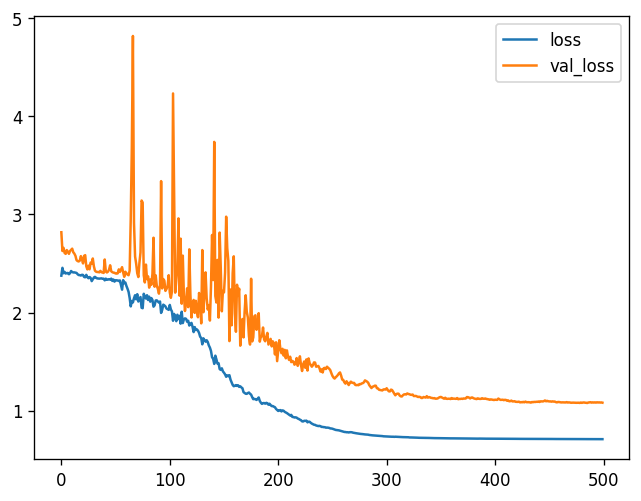

110/110 [==============================] - 3s 27ms/step - loss: 1.0658 - dense_1_loss: 0.5459 - dense_2_loss: 0.5199 - dense_1_accuracy: 0.9008 - dense_2_accuracy: 0.9231
[1.0657745599746704, 0.5459195375442505, 0.5198549032211304, 0.9008004665374756, 0.9230989217758179]


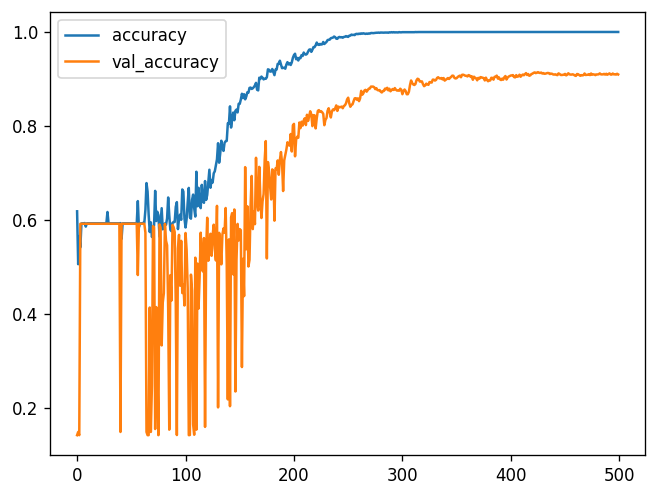

110/110 [==============================] - 3s 28ms/step - loss: 1.0658 - dense_1_loss: 0.5459 - dense_2_loss: 0.5199 - dense_1_accuracy: 0.9008 - dense_2_accuracy: 0.9231
[1.0657745599746704, 0.5459195375442505, 0.5198549032211304, 0.9008004665374756, 0.9230989217758179]


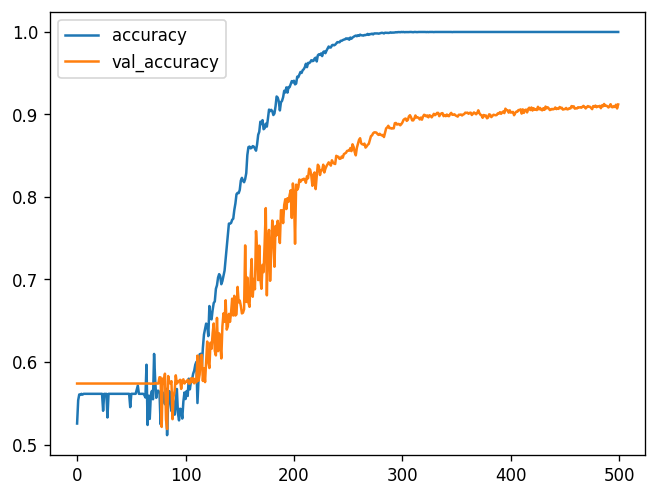

110/110 [==============================] - 3s 29ms/step - loss: 1.0658 - dense_1_loss: 0.5459 - dense_2_loss: 0.5199 - dense_1_accuracy: 0.9008 - dense_2_accuracy: 0.9231
[1.0657745599746704, 0.5459195375442505, 0.5198549032211304, 0.9008004665374756, 0.9230989217758179]


In [17]:
metrics2 = history.history
plt.plot(history.epoch, metrics2['loss'], metrics2['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
print(model.evaluate(ds_test))
plt.plot(history.epoch, metrics2['dense_1_accuracy'], metrics2['val_dense_1_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print(model.evaluate(ds_test))
plt.plot(history.epoch, metrics2['dense_2_accuracy'], metrics2['val_dense_2_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
print(model.evaluate(ds_test))

In [18]:
predictions = model.predict(ds_test)

110/110 [==============================] - 3s 22ms/step


In [19]:
p1, p2 = predictions
# p1, p2, p3, p4, p5, p6 = predictions

In [20]:
# predictions converted in human readable format
k = 1
for i in np.arange(p1.shape[0]):
    txt = "["
    txt = f"{txt} {predictionsToText(p1[i])}"
#     for j in p1[i]:
#         txt = f"{txt} {j:.4f}"
    txt = f"{txt} ::"
    txt = f"{txt} {predictionsToText(p2[i])}"
#     for j in p2[i]:
#         txt = f"{txt} {j:.4f}"
    txt = f"{k:04d}: {txt} ]"
    k = k + 1
    print(txt)

0001: [ 0.9249 0.0249 0.0249 0.0253 :: 0.9249 0.0222 0.0259 0.0270 ]
0002: [ 0.9028 0.0252 0.0417 0.0304 :: 0.3869 0.4694 0.0628 0.0809 ]
0003: [ 0.9171 0.0259 0.0305 0.0265 :: 0.9108 0.0265 0.0311 0.0316 ]
0004: [ 0.9135 0.0285 0.0296 0.0283 :: 0.9123 0.0285 0.0284 0.0308 ]
0005: [ 0.9291 0.0231 0.0260 0.0218 :: 0.9273 0.0218 0.0257 0.0253 ]
0006: [ 0.8488 0.0577 0.0482 0.0453 :: 0.7971 0.0883 0.0575 0.0571 ]
0007: [ 0.9103 0.0361 0.0251 0.0285 :: 0.7633 0.1102 0.0420 0.0845 ]
0008: [ 0.9266 0.0237 0.0279 0.0218 :: 0.9302 0.0215 0.0231 0.0252 ]
0009: [ 0.9297 0.0238 0.0257 0.0207 :: 0.9276 0.0217 0.0245 0.0262 ]
0010: [ 0.9250 0.0230 0.0266 0.0254 :: 0.9246 0.0216 0.0263 0.0274 ]
0011: [ 0.8928 0.0350 0.0384 0.0338 :: 0.8950 0.0341 0.0375 0.0334 ]
0012: [ 0.8793 0.0372 0.0398 0.0437 :: 0.8820 0.0368 0.0398 0.0414 ]
0013: [ 0.9064 0.0310 0.0318 0.0308 :: 0.9087 0.0270 0.0319 0.0325 ]
0014: [ 0.9206 0.0266 0.0280 0.0247 :: 0.9204 0.0243 0.0273 0.0280 ]
0015: [ 0.9085 0.0237 0.0370 0.030

0256: [ 0.9051 0.0319 0.0313 0.0317 :: 0.9107 0.0300 0.0288 0.0305 ]
0257: [ 0.9230 0.0243 0.0287 0.0240 :: 0.9221 0.0239 0.0271 0.0269 ]
0258: [ 0.9179 0.0248 0.0301 0.0272 :: 0.9134 0.0272 0.0297 0.0297 ]
0259: [ 0.9128 0.0281 0.0313 0.0278 :: 0.9142 0.0258 0.0289 0.0311 ]
0260: [ 0.9186 0.0264 0.0291 0.0260 :: 0.9165 0.0270 0.0285 0.0280 ]
0261: [ 0.9255 0.0243 0.0261 0.0240 :: 0.9216 0.0247 0.0252 0.0285 ]
0262: [ 0.8943 0.0323 0.0395 0.0340 :: 0.8853 0.0353 0.0339 0.0454 ]
0263: [ 0.9178 0.0265 0.0295 0.0261 :: 0.9217 0.0238 0.0288 0.0257 ]
0264: [ 0.9188 0.0251 0.0301 0.0260 :: 0.9167 0.0261 0.0288 0.0283 ]
0265: [ 0.9121 0.0295 0.0313 0.0270 :: 0.9173 0.0246 0.0276 0.0304 ]
0266: [ 0.9093 0.0301 0.0315 0.0290 :: 0.9103 0.0288 0.0304 0.0305 ]
0267: [ 0.9417 0.0199 0.0208 0.0176 :: 0.9380 0.0175 0.0229 0.0216 ]
0268: [ 0.9155 0.0251 0.0299 0.0295 :: 0.9075 0.0301 0.0281 0.0344 ]
0269: [ 0.9195 0.0243 0.0306 0.0256 :: 0.9172 0.0267 0.0284 0.0277 ]
0270: [ 0.9116 0.0283 0.0295 0.030

2656: [ 0.0792 0.5922 0.1981 0.1305 :: 0.6583 0.1248 0.1295 0.0874 ]
2657: [ 0.0645 0.1174 0.7352 0.0829 :: 0.0700 0.7809 0.0630 0.0861 ]
2658: [ 0.1307 0.1630 0.1742 0.5321 :: 0.1534 0.4445 0.2900 0.1121 ]
2659: [ 0.0765 0.3322 0.5607 0.0306 :: 0.1239 0.5412 0.2650 0.0699 ]
2660: [ 0.0809 0.0485 0.7643 0.1064 :: 0.4928 0.2993 0.1375 0.0704 ]
2661: [ 0.0724 0.0548 0.7918 0.0810 :: 0.0440 0.8258 0.0545 0.0757 ]
2662: [ 0.1267 0.4869 0.2927 0.0938 :: 0.0989 0.6865 0.1387 0.0759 ]
2663: [ 0.0423 0.0564 0.8111 0.0902 :: 0.9462 0.0139 0.0191 0.0209 ]
2664: [ 0.0348 0.1250 0.8286 0.0116 :: 0.2103 0.5539 0.1505 0.0853 ]
2665: [ 0.0904 0.1778 0.6443 0.0875 :: 0.7963 0.0627 0.0970 0.0439 ]
2666: [ 0.1097 0.2356 0.5985 0.0563 :: 0.1534 0.5197 0.2183 0.1085 ]
2667: [ 0.0979 0.6892 0.1598 0.0531 :: 0.6199 0.1197 0.1275 0.1329 ]
2668: [ 0.1102 0.4549 0.3431 0.0919 :: 0.7835 0.0768 0.0796 0.0601 ]
2669: [ 0.0171 0.0300 0.9342 0.0187 :: 0.9388 0.0173 0.0213 0.0226 ]
2670: [ 0.0881 0.0663 0.7002 0.145

3039: [ 0.0436 0.0478 0.0712 0.8374 :: 0.9225 0.0177 0.0327 0.0271 ]
3040: [ 0.0653 0.0510 0.1168 0.7668 :: 0.8033 0.0836 0.0445 0.0686 ]
3041: [ 0.1433 0.1402 0.2574 0.4590 :: 0.8679 0.0609 0.0380 0.0332 ]
3042: [ 0.0132 0.0140 0.0154 0.9574 :: 0.8821 0.0564 0.0327 0.0288 ]
3043: [ 0.2439 0.1644 0.5277 0.0640 :: 0.1205 0.3652 0.2625 0.2517 ]
3044: [ 0.0427 0.0486 0.1062 0.8026 :: 0.9264 0.0254 0.0244 0.0238 ]
3045: [ 0.0532 0.0355 0.1571 0.7542 :: 0.8796 0.0419 0.0425 0.0361 ]
3046: [ 0.0218 0.0273 0.0532 0.8976 :: 0.6807 0.2179 0.0441 0.0572 ]
3047: [ 0.0563 0.0402 0.1513 0.7522 :: 0.6647 0.2083 0.0728 0.0543 ]
3048: [ 0.0176 0.0146 0.0067 0.9611 :: 0.8840 0.0525 0.0359 0.0276 ]
3049: [ 0.5742 0.1630 0.1269 0.1360 :: 0.1100 0.3222 0.4253 0.1425 ]
3050: [ 0.0396 0.0352 0.1389 0.7863 :: 0.7370 0.1538 0.0577 0.0515 ]
3051: [ 0.0241 0.0160 0.0150 0.9449 :: 0.8769 0.0586 0.0237 0.0407 ]
3052: [ 0.0178 0.0302 0.0460 0.9060 :: 0.9489 0.0145 0.0236 0.0131 ]
3053: [ 0.0078 0.0065 0.0040 0.981

In [21]:
def PlotDataset(ytrue1, ytrue2):
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
    #print(ytrue1)
    bar1 = np.zeros(4)
    bar2 = np.zeros(4)
    #print(hist1)
    carlabels1 = ['None', '1Left', '2Left', '3Left']
    carlabels2 = ['None', '1Right', '2Right', '3Right']
    
    for i in range(len(ytrue1)):
        bar1 += ytrue1[i]
        bar2 += ytrue2[i]
#     print(bar1)
#     print(bar2)
    
    plt.bar(carlabels1, bar1)
    plt.title("ds_test_o Bar Left")
    plt.show()
    plt.bar(carlabels2, bar2)
    plt.title("ds_test_o Bar Right")
    plt.show()

In [22]:
a = np.random.rand(10,4)
print(a)
# z = np.zeros((10))
# print(z)
print('____________')
for num in a:
    z = np.zeros((4))
    a_max_i = np.argmax(num)
#     print(a_max_i)
    z[a_max_i] = 1
    print(z)
#     print(z[a_max_i])

[[0.46818255 0.43015272 0.02401774 0.45429259]
 [0.59775611 0.43660842 0.71172322 0.78758971]
 [0.79042654 0.3808235  0.70495782 0.57856616]
 [0.72316396 0.66517229 0.55168964 0.37234927]
 [0.22667358 0.86093663 0.74884556 0.72564321]
 [0.10334644 0.1396504  0.48060539 0.79754772]
 [0.82863426 0.01216599 0.59990757 0.62890541]
 [0.77845291 0.98355929 0.21244477 0.94064409]
 [0.48574582 0.15152726 0.55251071 0.75945315]
 [0.68894725 0.0495967  0.15930101 0.03806689]]
____________
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]


In [1]:
def ConfusionMatrix(pred1, pred2, ytrue1, ytrue2):
    #print(tf.reshape(ytrue, [-1]))
    
#     ytrue1 = ytrue1.numpy()
#     ytrue2 = ytrue2.numpy()
#     pred1 = (np.round(pred1, 0))
#     pred2 = (np.round(pred2, 0))
    predictions1 = pred1
    predictions2 = pred2
    pred1 = []
    pred2 = []
    
#     for i,pred in enumerate(predictions1):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred1.append(a)
        
#     for i,pred in enumerate(predictions2):
#         a = np.where(pred == np.max(pred), 1, 0)
#         pred2.append(a)
        
    for num in predictions1:
        z = np.zeros((4))
        predictions1_max_i = np.argmax(num)
#         print(predictions1_max_i)
        z[predictions1_max_i] = 1
        pred1.append(z)
        
    for num in predictions2:
        z = np.zeros((4))
        predictions2_max_i = np.argmax(num)
        z[predictions2_max_i] = 1
        pred2.append(z)

    
    #print(pred, pred.shape)
    #print((pred.flatten()))

    #print(pred.flatten()) #tf.reshape(ytrue, [-1])
    #ARRAYS OF 1s AND 0s HAVE TO BE TRANSLATED INTO LABELS
    
    #print(len(ytrue1))
    #print(len(pred1))
    conf_matrix1 = np.zeros((4,4))
    conf_matrix2 = np.zeros((4,4))
    conf_matrix3 = np.zeros((4,4))
    conf_matrix4 = np.zeros((4,4))
    #print(conf_matrix1)

    for i in range(len(ytrue1)):
        #print(ytrue[i])
        #print(pred[i])
        mat11 = ytrue1[i] #labels left
        mat11 = mat11.reshape(4,1)
        mat12 = pred1[i] #predictions left
        mat12 = mat12.reshape(1,4)
        mat21 = ytrue2[i] #labels right
        mat21 = mat21.reshape(4,1)
        mat22 = pred2[i] #predictions right
        mat22 = mat22.reshape(1,4)
        #print(mat1)
        #print(mat2)
                
        conf_matrix1 += np.dot(mat11, mat12) #L2L
        conf_matrix2 += np.dot(mat11, mat22) #L2R
        conf_matrix3 += np.dot(mat21, mat12) #R2L
        conf_matrix4 += np.dot(mat21, mat22) #R2R
    #print(conf_matrix1.shape)
    #print(conf_matrix1)
    #print(conf_matrix2.shape)
    #print(conf_matrix2)
    
#     confusion_mtx = tf.math.confusion_matrix(ytrue.flatten(), pred.flatten(), num_classes=8, dtype=tf.dtypes.float32,) #, num_classes=8
#     #print(confusion_mtx)
    carlabels1 = ['None', '1Left', '2Left', '3Left']
    carlabels2 = ['None', '1Right', '2Right', '3Right']
    #fig, axs = plt.subplots(2, 2)
    
    sns.heatmap(conf_matrix1, xticklabels=carlabels1, yticklabels=carlabels1, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    sns.heatmap(conf_matrix4, xticklabels=carlabels2, yticklabels=carlabels2, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
#     sns.heatmap(conf_matrix2, xticklabels=carlabels2, yticklabels=carlabels2, 
#             annot=True, fmt='g')
#     plt.xlabel('Prediction')
#     plt.ylabel('Label')
# #     plt.show()
    

    fig,axn = plt.subplots(2, 2, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    
    conf_matrixes = [conf_matrix1, conf_matrix2, conf_matrix3, conf_matrix4]
    itr = iter(conf_matrixes)
#     for ax in axn.flat:
#         sns.heatmap(next(itr), xticklabels=carlabels1, yticklabels=carlabels1, 
#                 annot=True, fmt='g', ax=ax)
#         plt.xlabel('Prediction')
#         plt.ylabel('Label')
#     plt.show()
    
    for i, ax in enumerate(axn.flat):
        sns.heatmap(next(itr), xticklabels=carlabels2, yticklabels=carlabels1, 
                    annot=True, fmt='g', ax=ax,
                    cbar=i == 0,
                    #vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)

#     fig.tight_layout(rect=[0, 0, 1, 1])
    plt.xlabel('Prediction')
    plt.ylabel('Label')
#     plt.show()
    
    for i, matrix in enumerate(conf_matrixes):
        if i == 0:
            print("Left to Left")
        if i == 1:
            print("Left to Right")
        if i == 2:
            print("Right to Left")
        if i == 3:
            print("Right to Right")
        row0sum = np.sum(matrix[0])
        row1sum = np.sum(matrix[1])
        row2sum = np.sum(matrix[2])
        row3sum = np.sum(matrix[3])
        col0sum = np.sum(matrix[:,0])
        col1sum = np.sum(matrix[:,1])
        col2sum = np.sum(matrix[:,2])    
        col3sum = np.sum(matrix[:,3])
        
        d0 = matrix[0,0]
        d1 = matrix[1,1]
        d2 = matrix[2,2]
        d3 = matrix[3,3]
        
        precision0 = round((100*d0/row0sum),2)
        precision1 = round((100*d1/row1sum),2)
        precision2 = round((100*d2/row2sum),2)
        precision3 = round((100*d3/row3sum),2)
        recall0 = round((100*d0/col0sum),2)
        recall1 = round((100*d1/col1sum),2)
        recall2 = round((100*d2/col2sum),2)
        recall3 = round((100*d3/col3sum),2)
        
        print("PRECISIONS:",'\t',"None - ", precision0, " 1 Car - ", precision1, " 2 Car - ", precision2, " 3 Car - ", precision3)
        print("RECALLS:",'\t',"None - ", recall0, " 1 Car - ", recall1, " 2 Car - ", recall2, " 3 Car - ", recall3)
#         print("row 0", matrix[0], row0sum, d0, d1, d2, d3)
#         print("column 0", matrix[:,0], col0sum)
    plt.show()

In [2]:
# Count pitcures in test dataset
sum = 0
test_names_arr = tfds.as_numpy(ds_test_names_o)
print(len(test_names_arr))
for num in test_names_arr:
    print(len(num))
    sum += len(num)
print(sum)

NameError: name 'tfds' is not defined

4/4 [==============================] - 0s 65ms/step


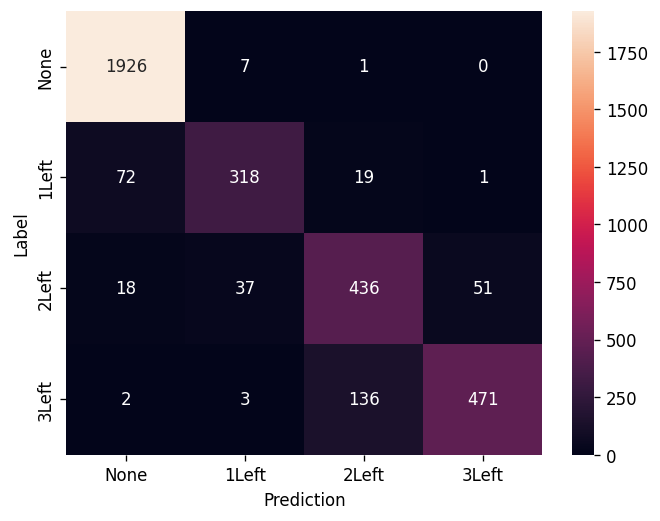

Left to Left
PRECISIONS: 	 None -  99.59  1 Car -  77.56  2 Car -  80.44  3 Car -  76.96
RECALLS: 	 None -  95.44  1 Car -  87.12  2 Car -  73.65  3 Car -  90.06
Left to Right
PRECISIONS: 	 None -  48.66  1 Car -  16.83  2 Car -  3.14  3 Car -  0.16
RECALLS: 	 None -  42.16  1 Car -  13.94  2 Car -  4.52  3 Car -  0.25
Right to Left
PRECISIONS: 	 None -  44.01  1 Car -  10.11  2 Car -  3.71  3 Car -  0.0
RECALLS: 	 None -  47.13  1 Car -  15.62  2 Car -  2.53  3 Car -  0.0
Right to Right
PRECISIONS: 	 None -  99.35  1 Car -  79.08  2 Car -  76.73  3 Car -  88.35
RECALLS: 	 None -  96.19  1 Car -  90.1  2 Car -  82.45  3 Car -  82.53


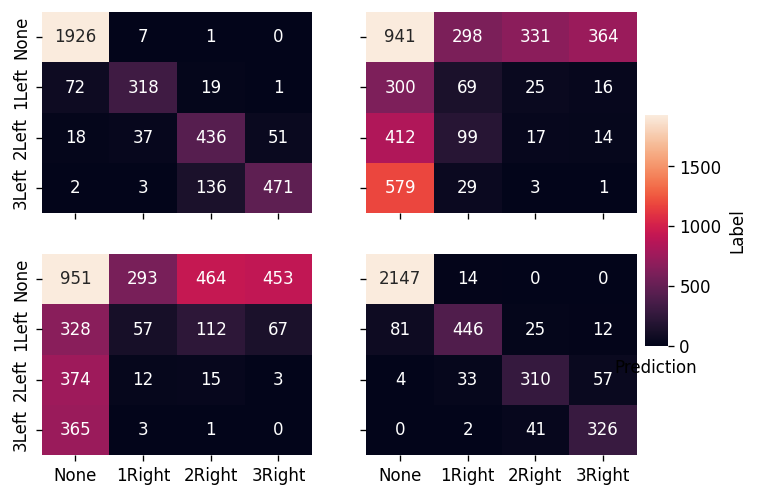

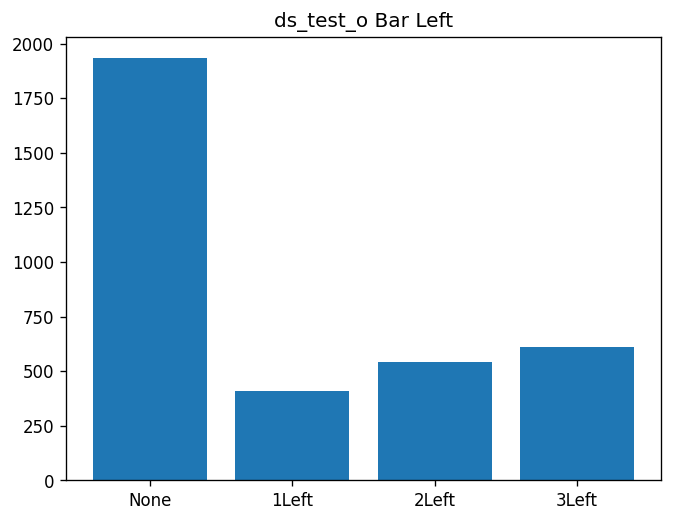

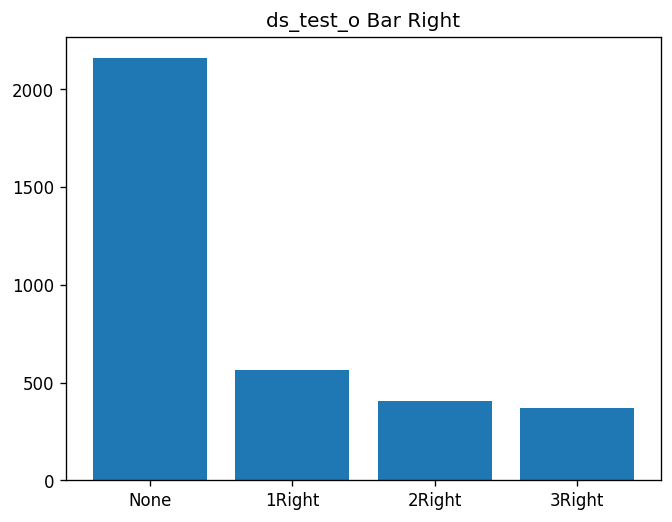

In [25]:
# print(p1.shape)
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)
p1total = list()
p2total = list()
y1total = list()
y2total = list()

# for i in np.arange(13):
for i in np.arange(len(tfds.as_numpy(ds_test_names_o))):
    img, labels = next(it1)
    batch_names = next(it2)
    predictions_test = model.predict(img)
    p1, p2 = predictions_test
    y1, y2 = labels
    if i == 0:
        y1total = y1.numpy()
        p1total = p1
        y2total = y2.numpy()
        p2total = p2
    else:
        y1total = np.concatenate((y1total, y1.numpy()))
        y2total = np.concatenate((y2total, y2.numpy()))
        p1total = np.concatenate((p1total, p1))
        p2total = np.concatenate((p2total, p2))
#     PlotDataset(y1,y2)
# print((np.array(y1total)).shape)
# print((np.array(p1total)).shape)
ConfusionMatrix(p1total, p2total, y1total, y2total)
PlotDataset(y1total,y2total)
    #print(np.shape(predictions))
    #print(np.shape(labels))

4/4 [==============================] - 0s 27ms/step


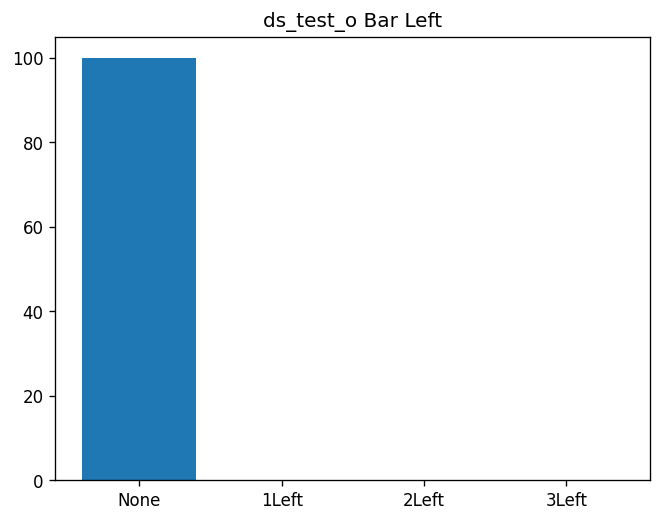

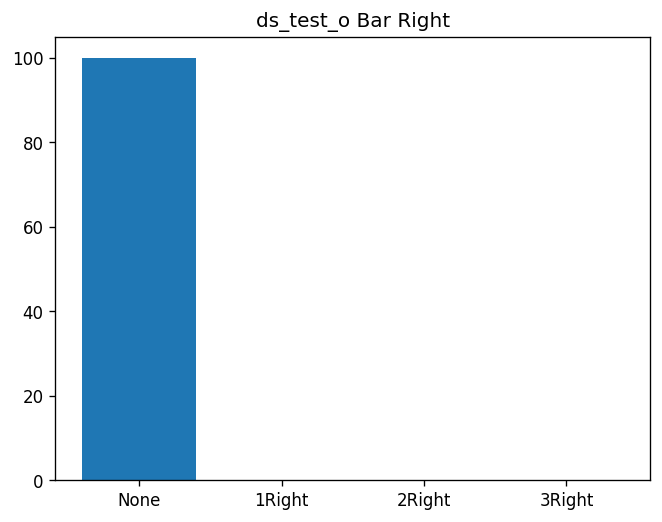

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


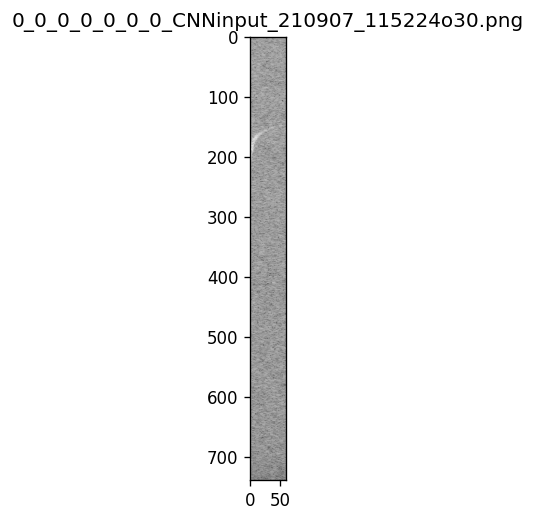

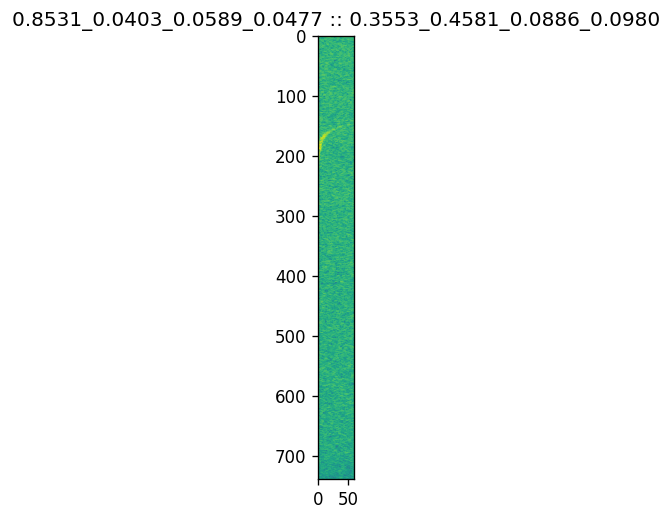

4/4 [==============================] - 0s 26ms/step


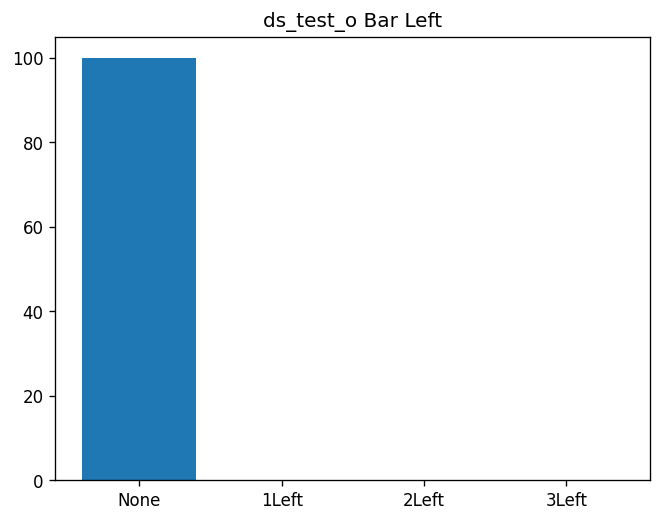

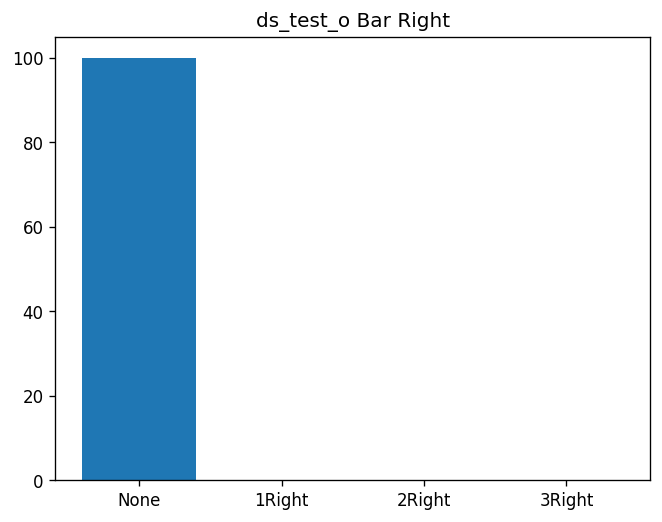

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


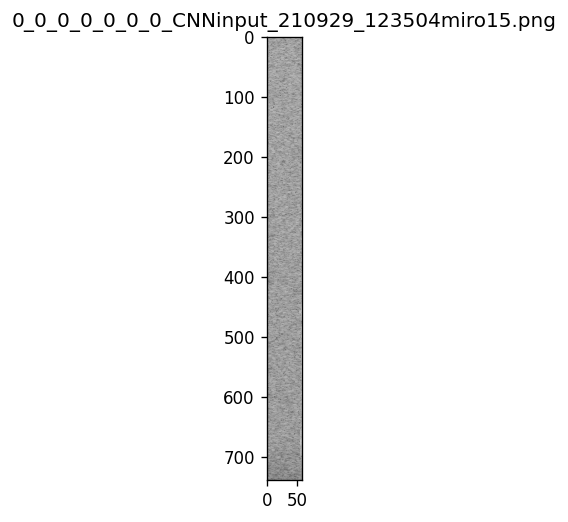

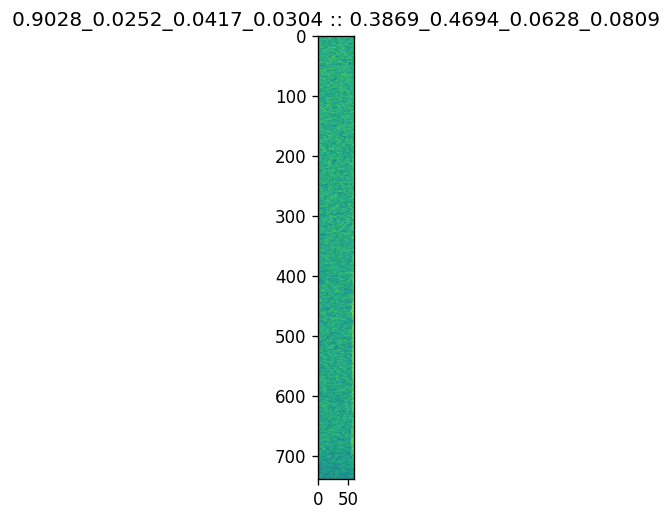

4/4 [==============================] - 0s 27ms/step


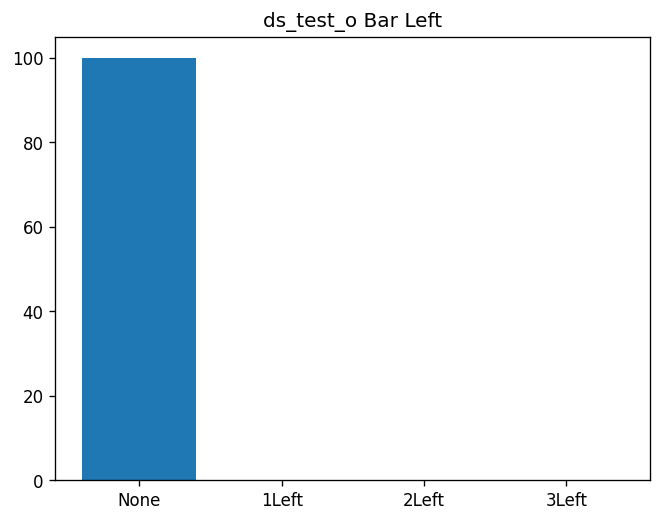

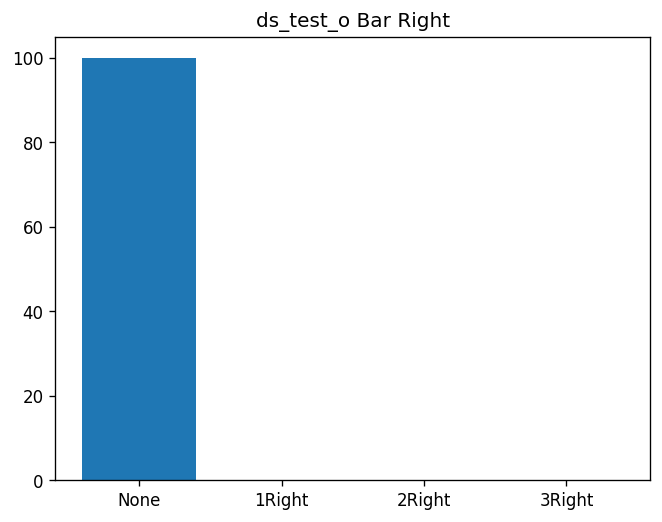

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


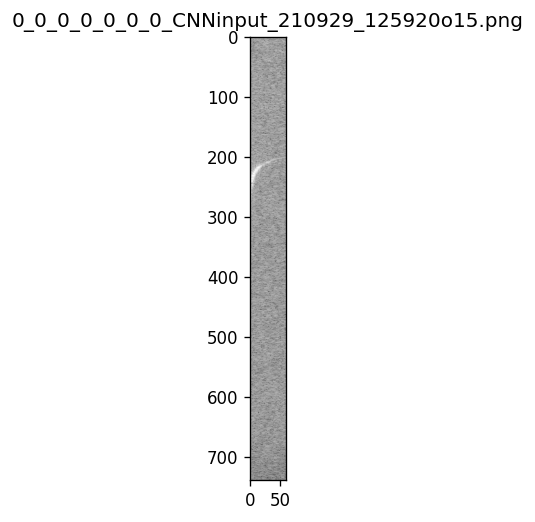

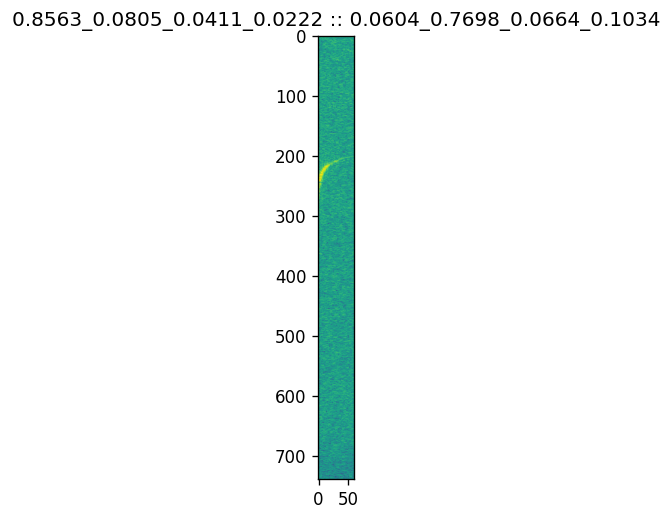

4/4 [==============================] - 0s 25ms/step


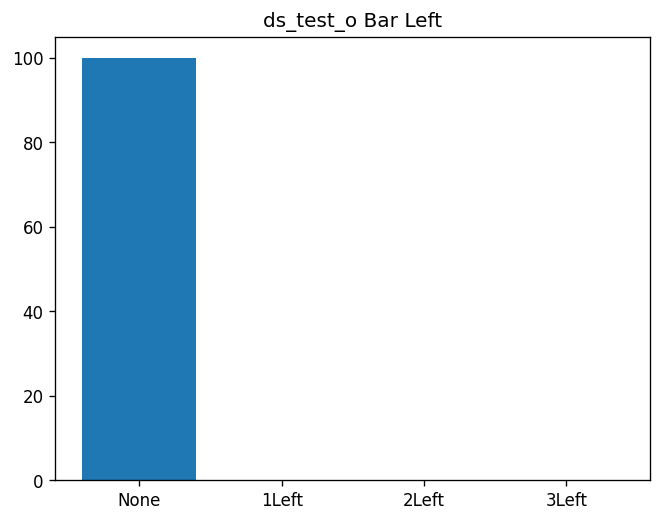

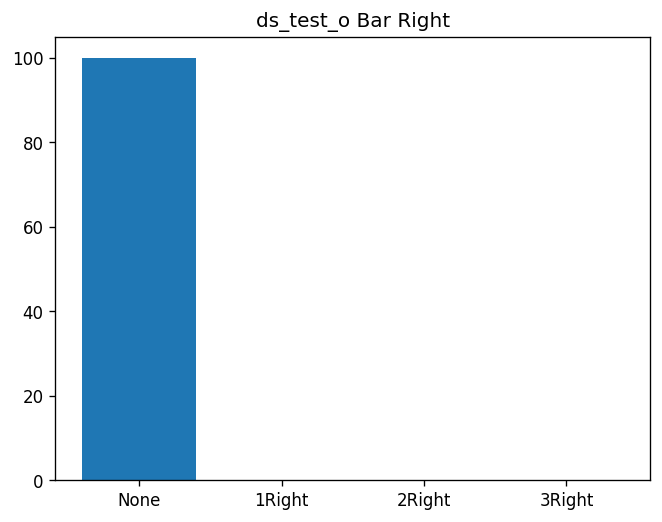

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


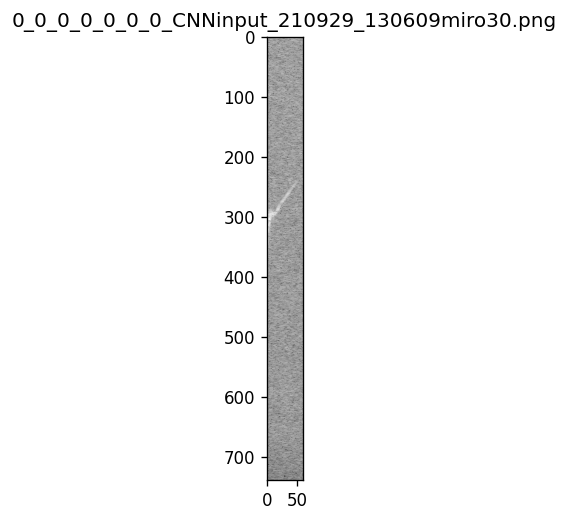

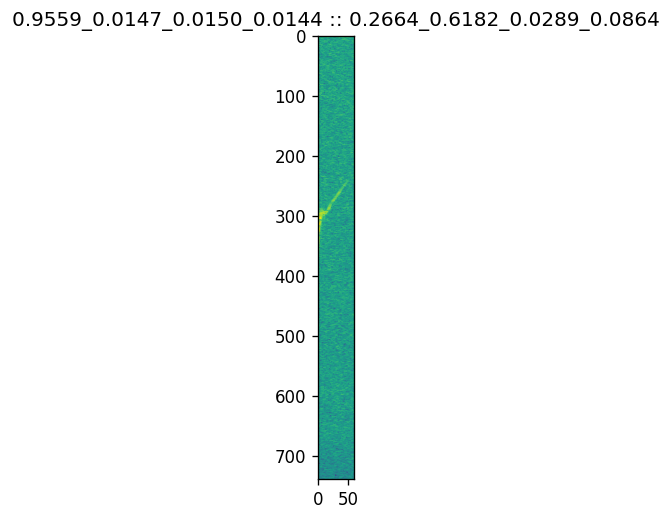

4/4 [==============================] - 0s 26ms/step


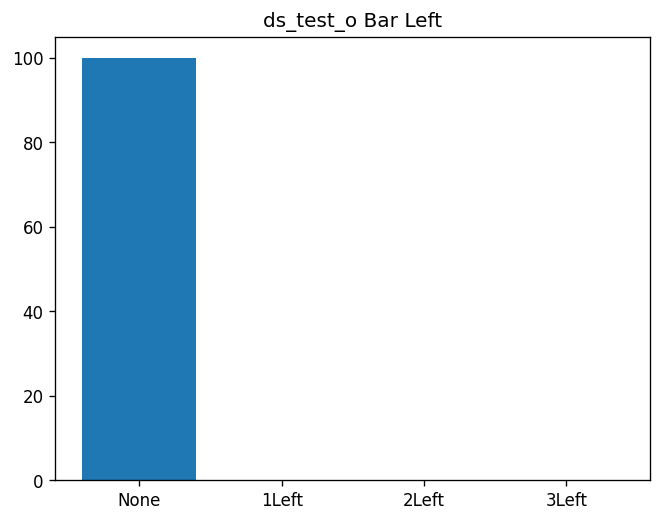

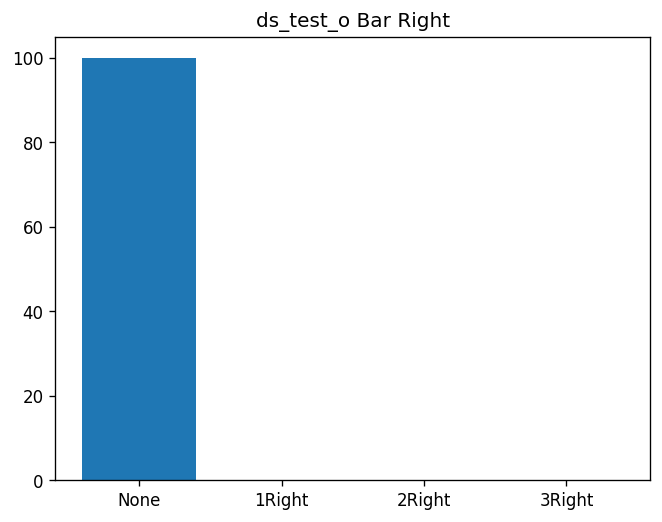

4/4 [==============================] - 0s 25ms/step


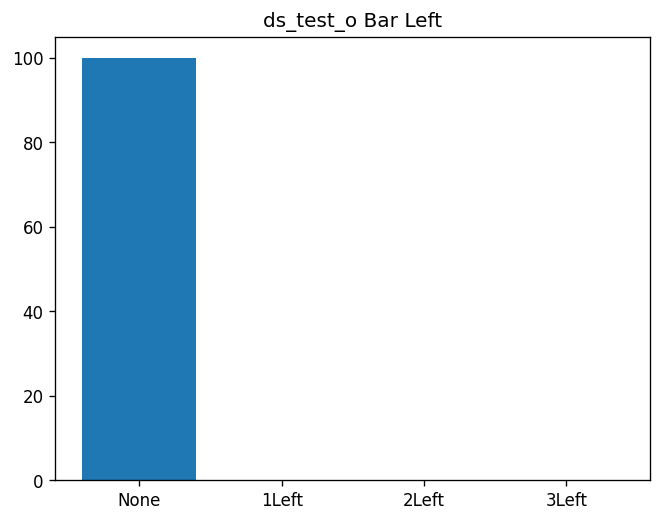

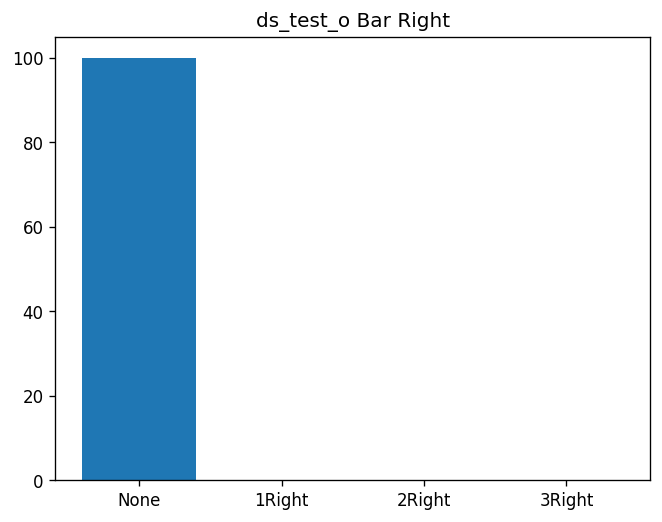

4/4 [==============================] - 0s 25ms/step


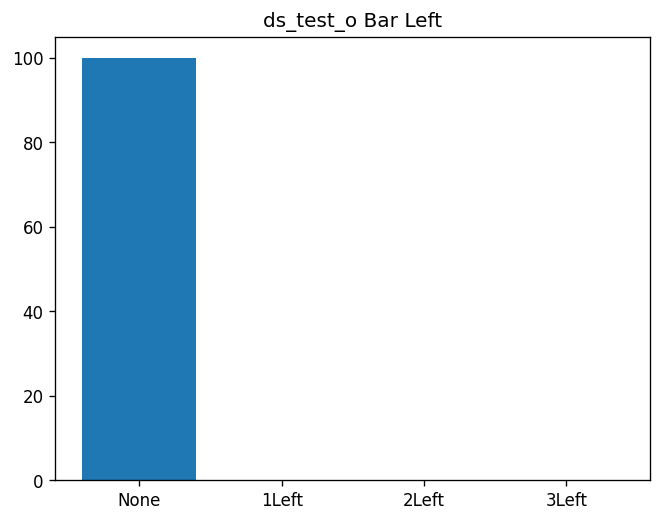

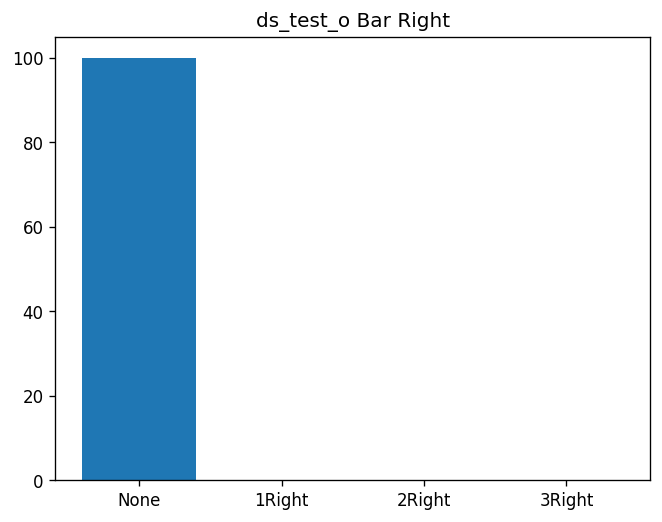

4/4 [==============================] - 0s 25ms/step


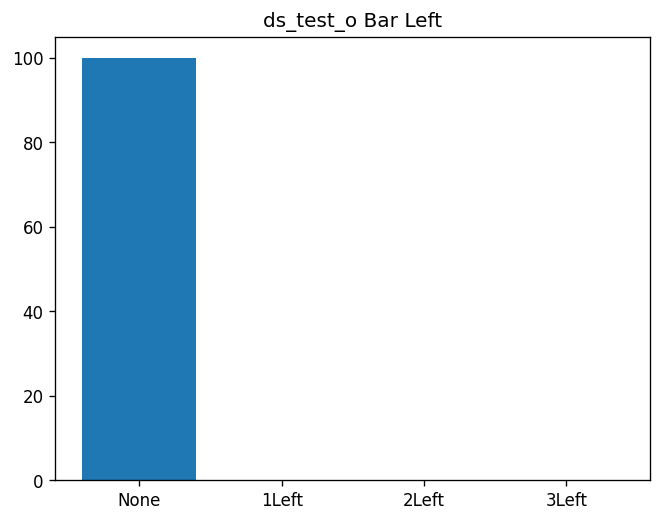

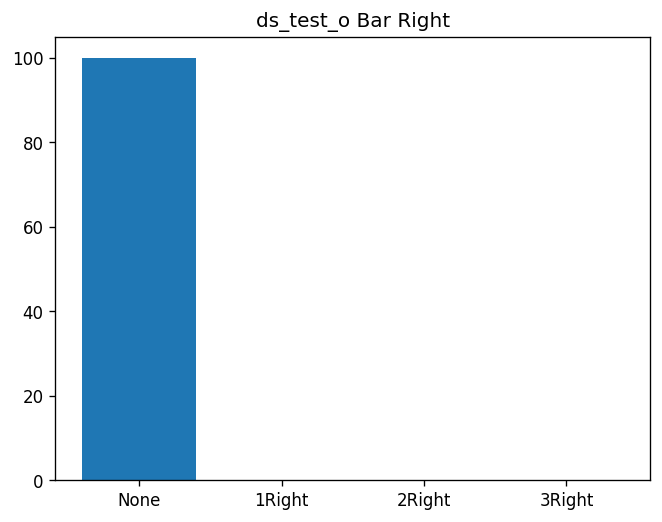

4/4 [==============================] - 0s 24ms/step


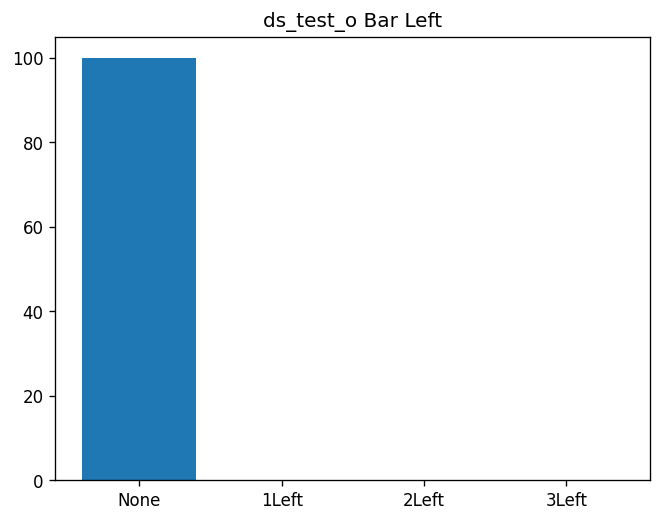

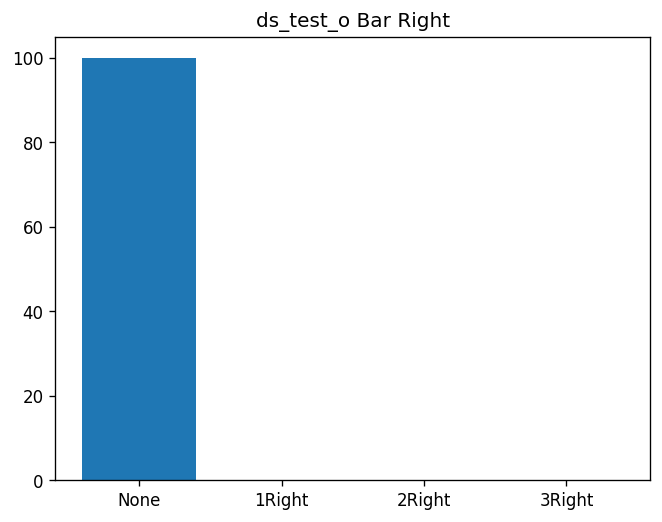

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


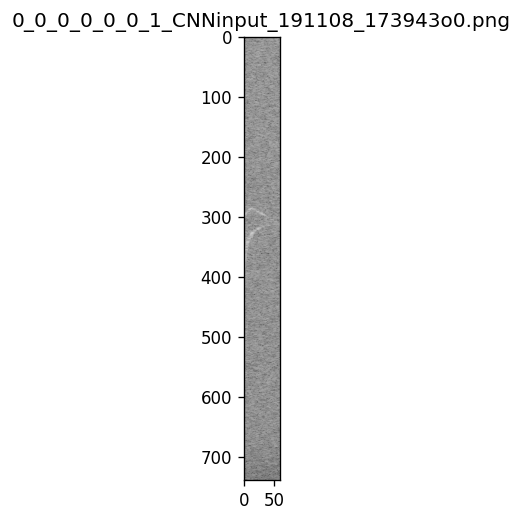

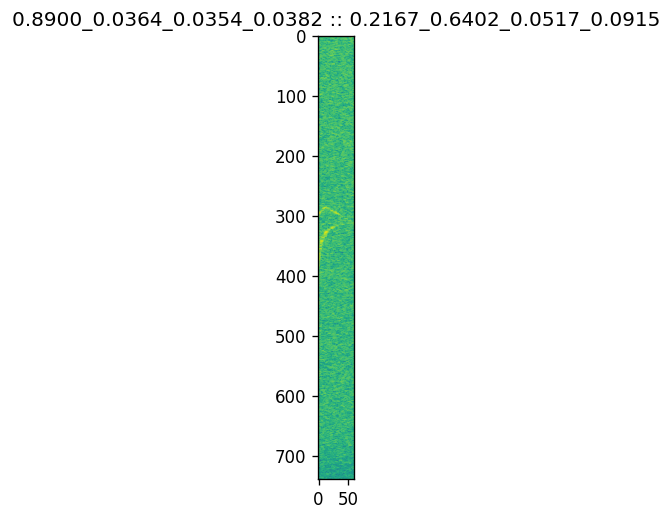

4/4 [==============================] - 0s 27ms/step


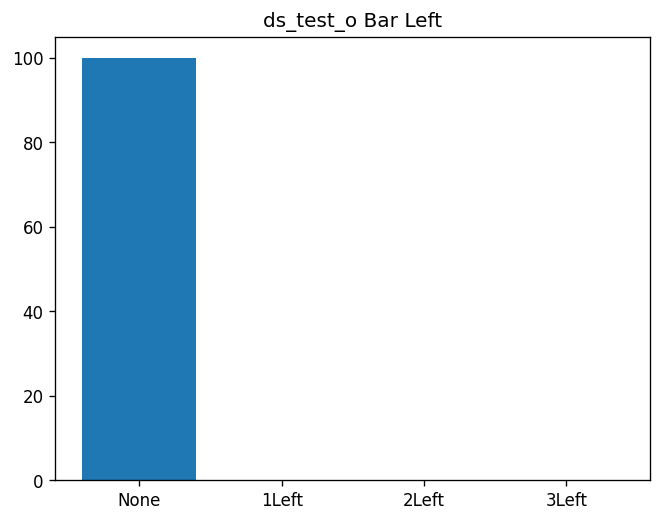

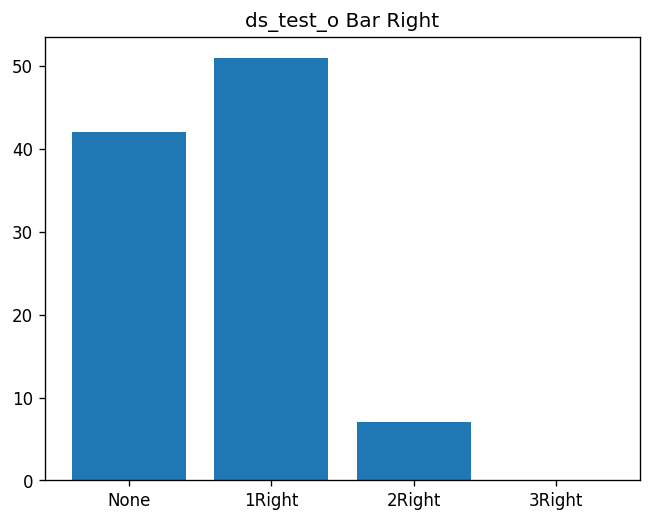

Labels:  [1. 0. 0. 0.] [1. 0. 0. 0.]
Predictions:  [0. 1. 0. 0.] [1. 0. 0. 0.]


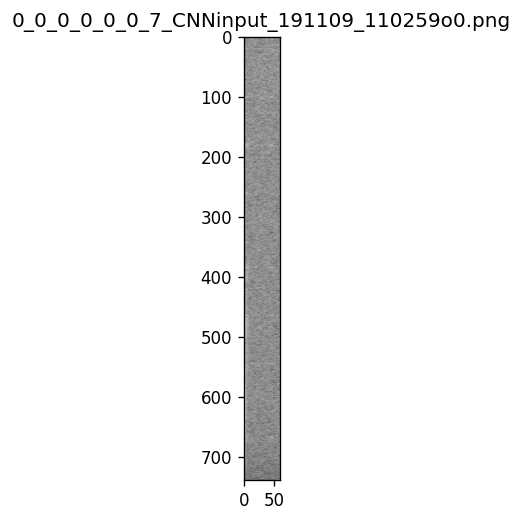

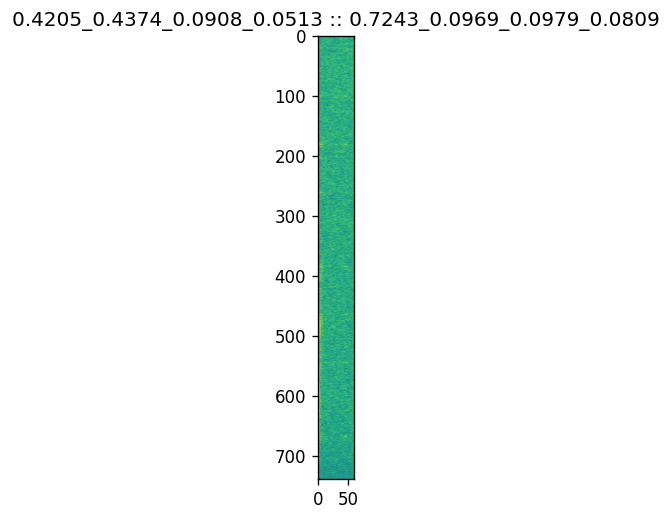

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


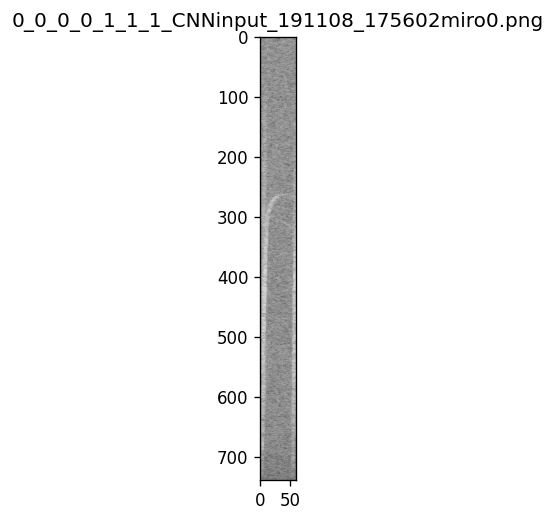

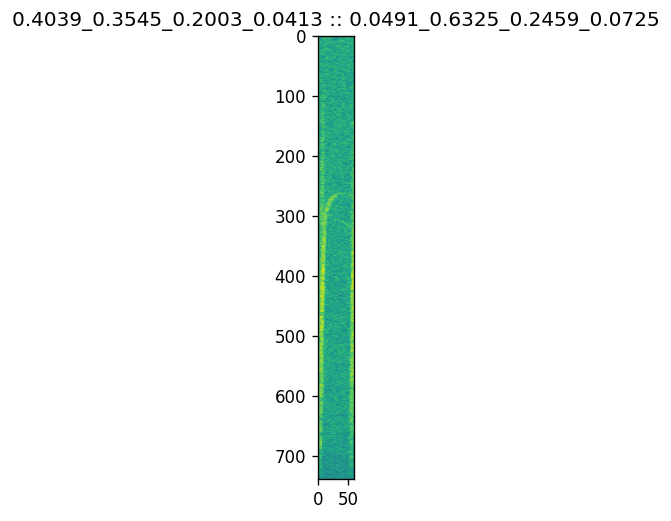

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


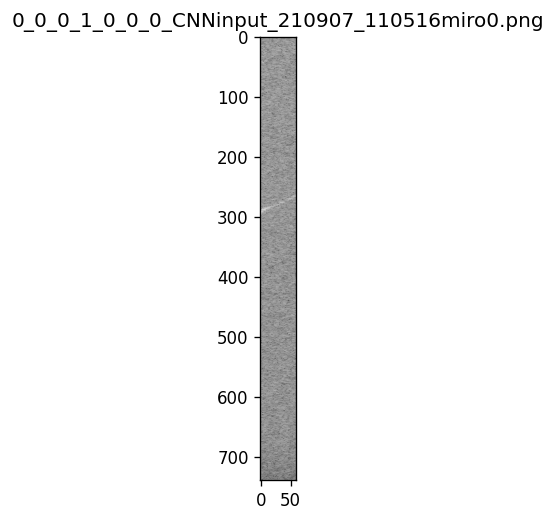

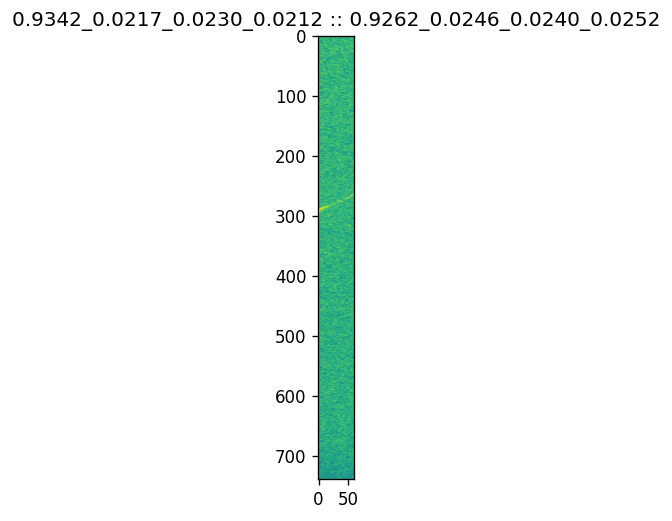

4/4 [==============================] - 0s 26ms/step


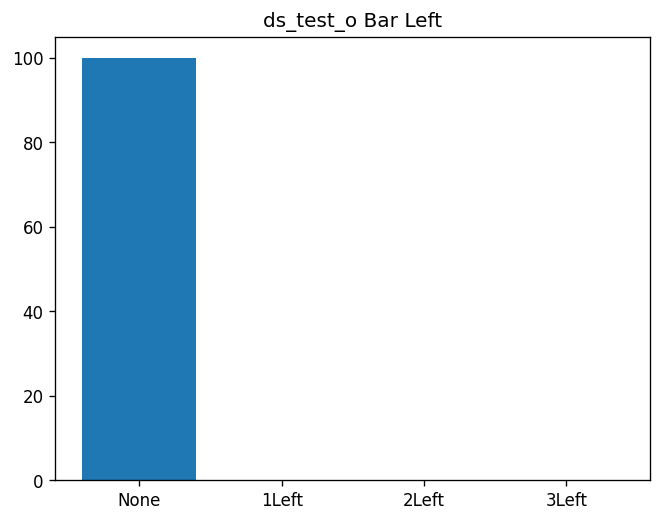

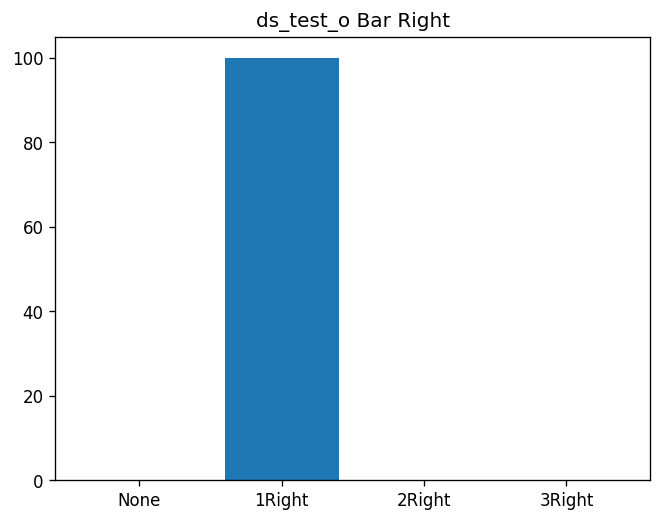

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [0. 1. 0. 0.] [1. 0. 0. 0.]


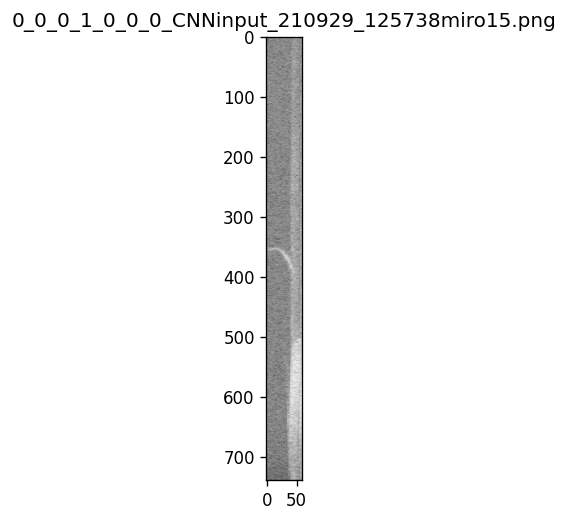

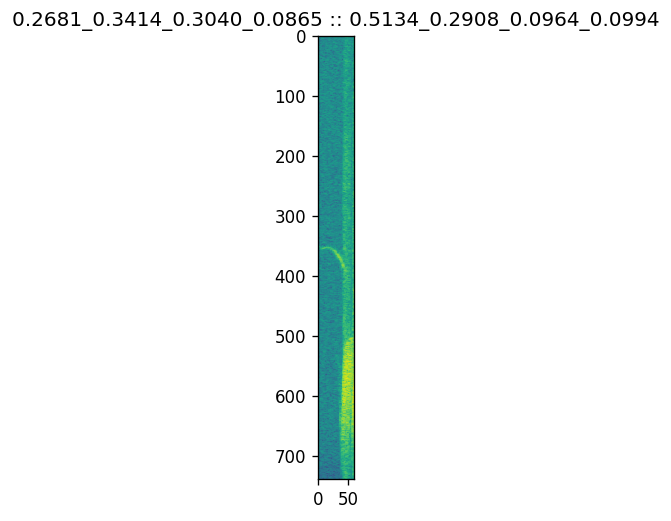

4/4 [==============================] - 0s 26ms/step


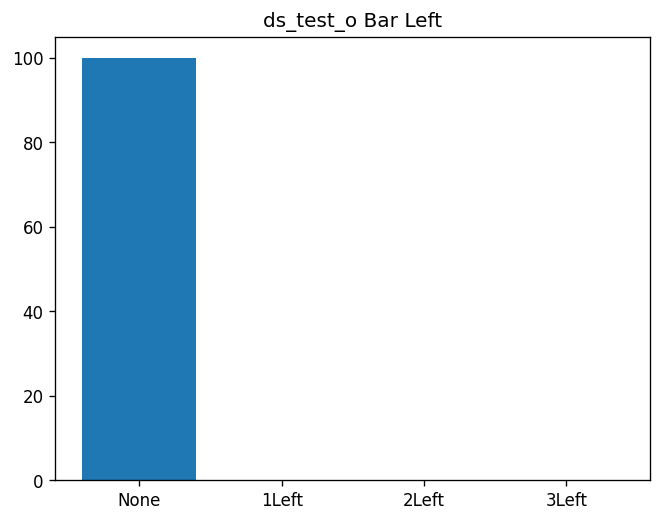

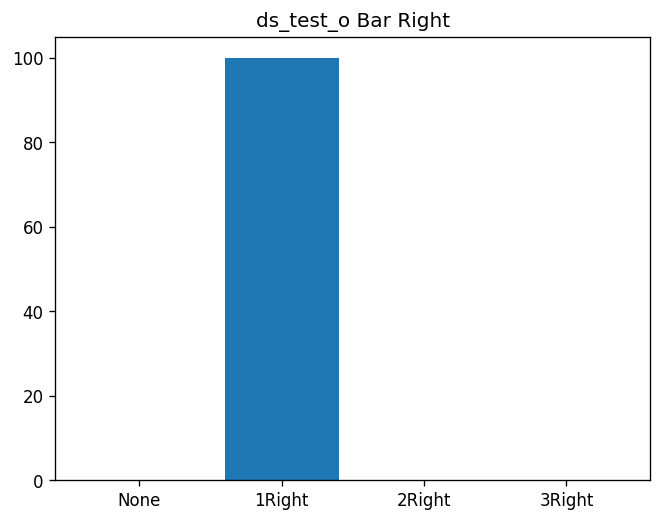

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


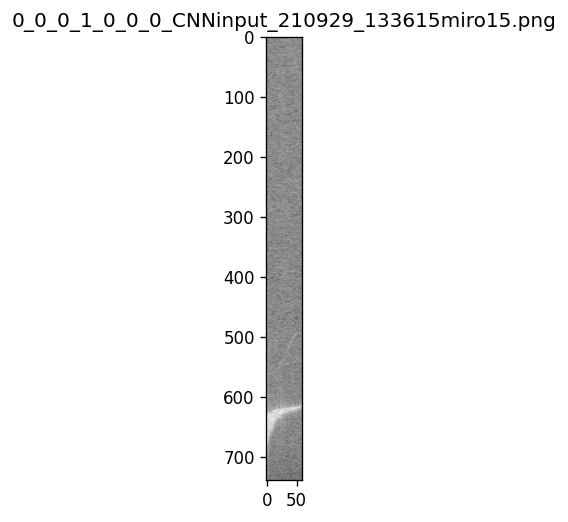

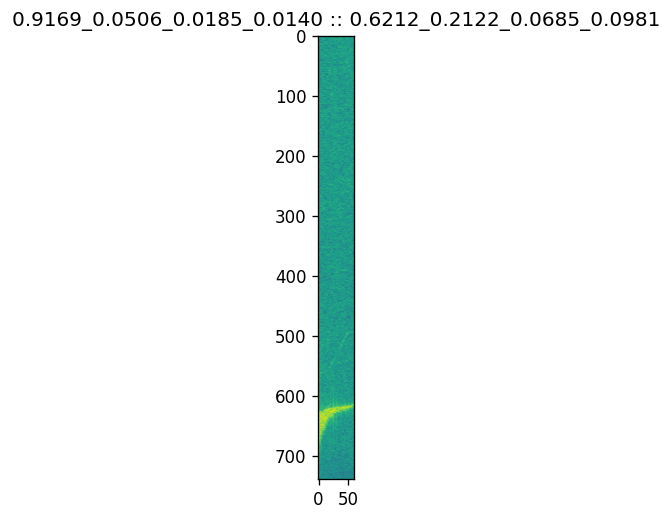

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [0. 1. 0. 0.] [0. 1. 0. 0.]


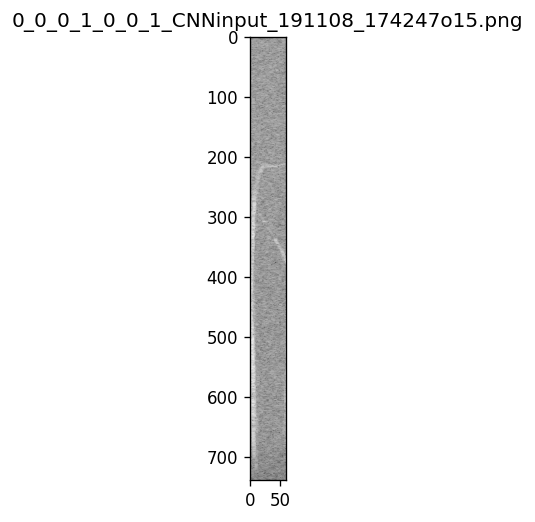

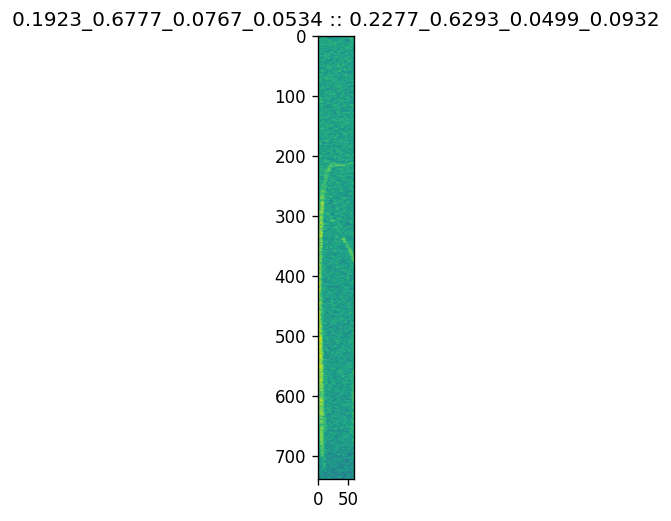

4/4 [==============================] - 0s 25ms/step


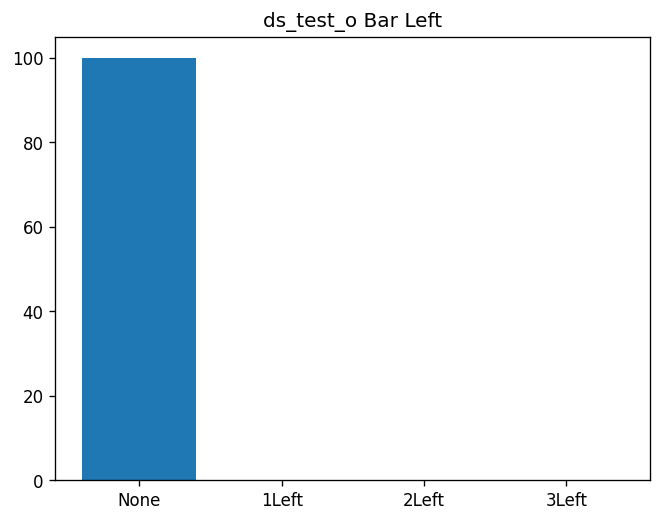

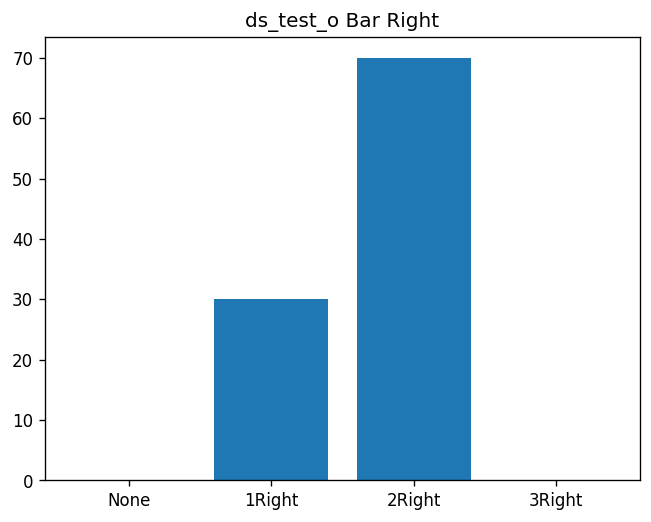

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [1. 0. 0. 0.]


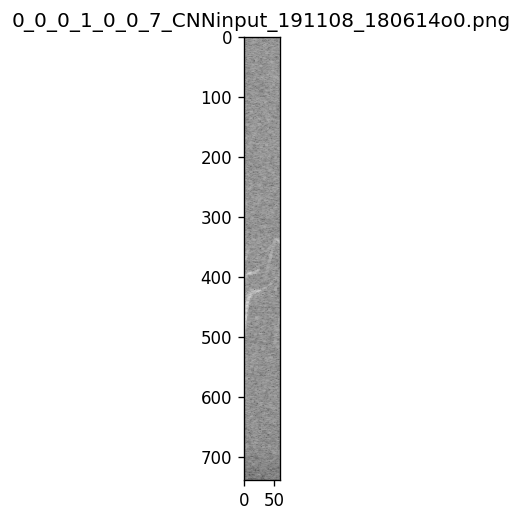

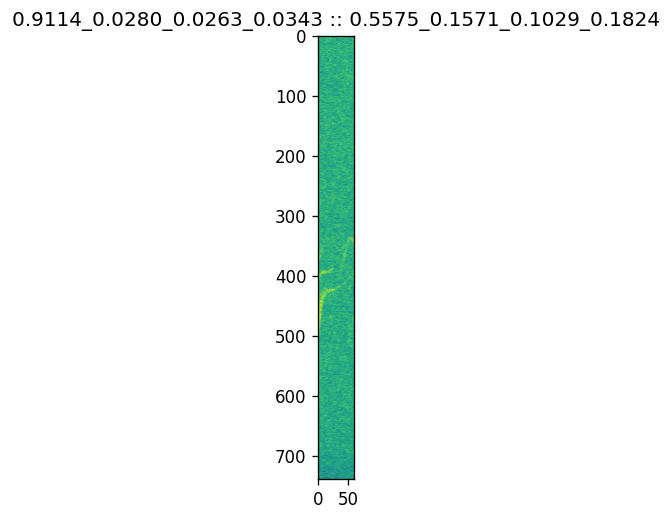

Labels:  [1. 0. 0. 0.] [0. 1. 0. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 1. 0.]


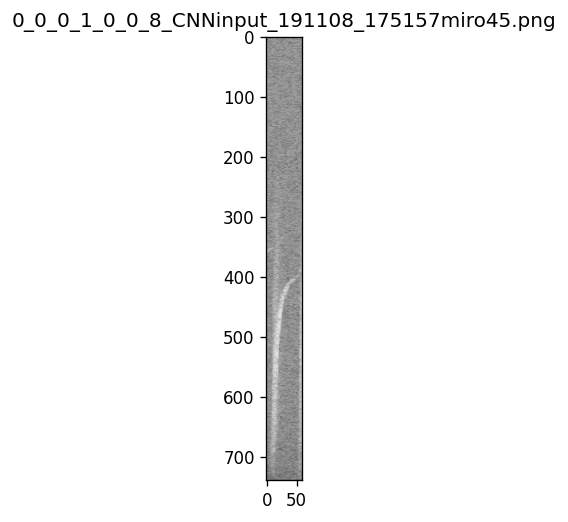

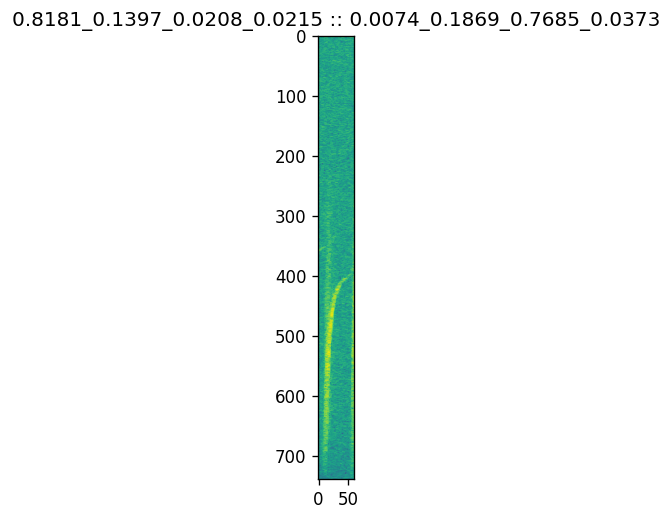

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 1. 0. 0.]


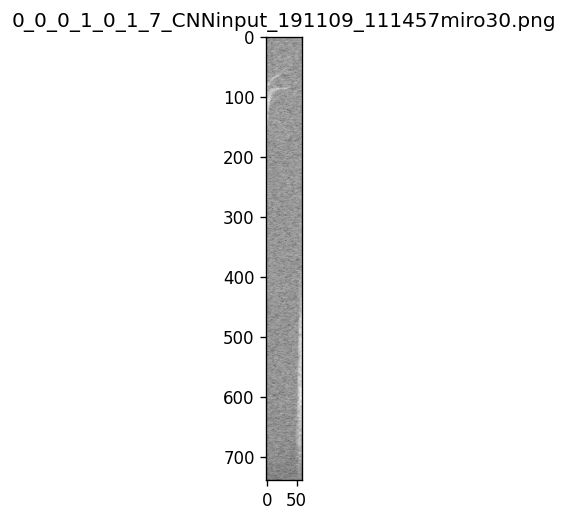

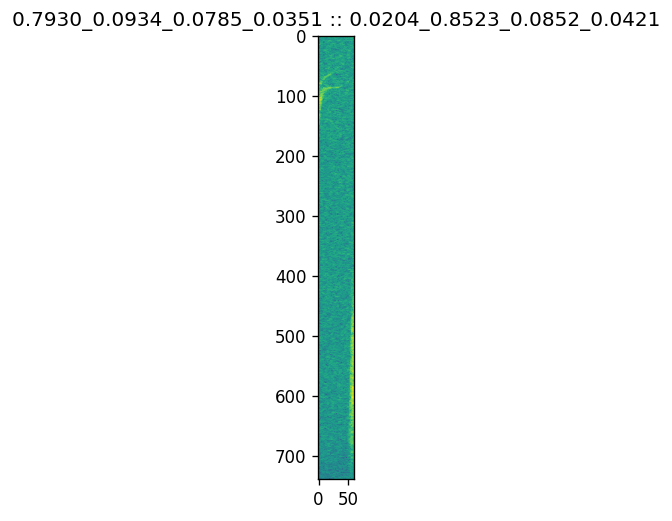

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


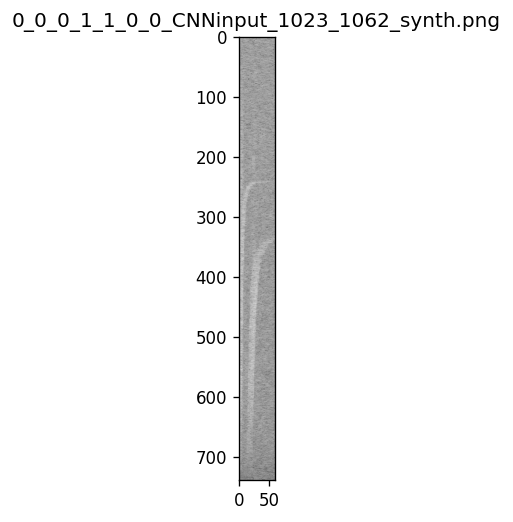

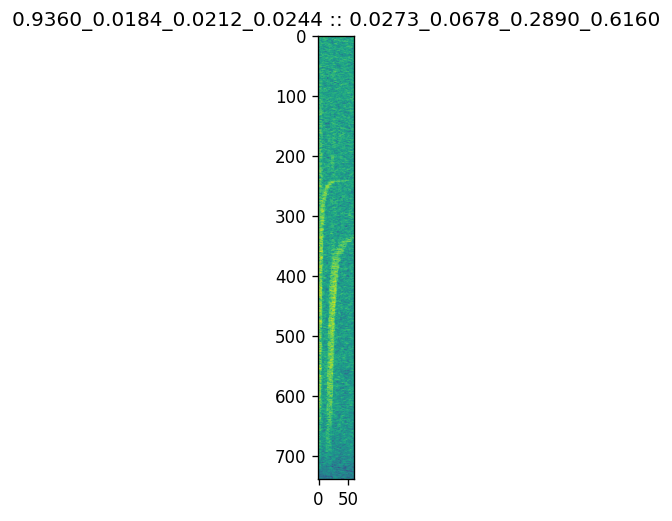

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


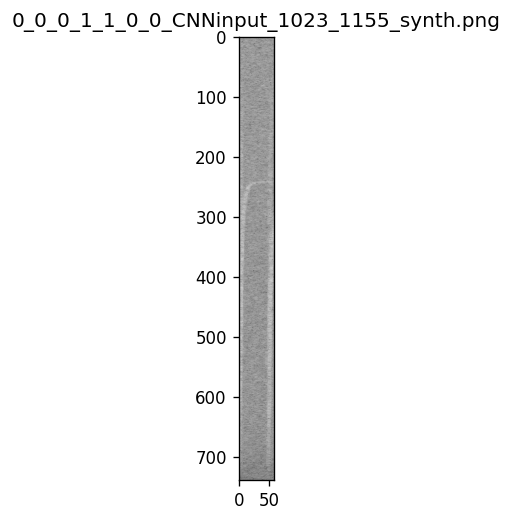

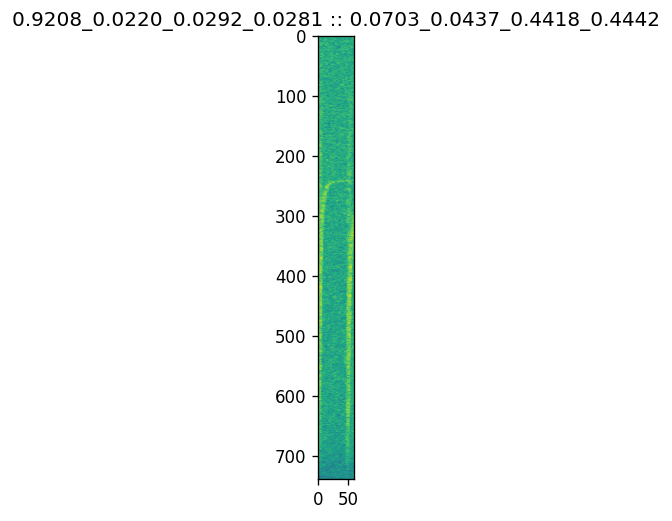

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


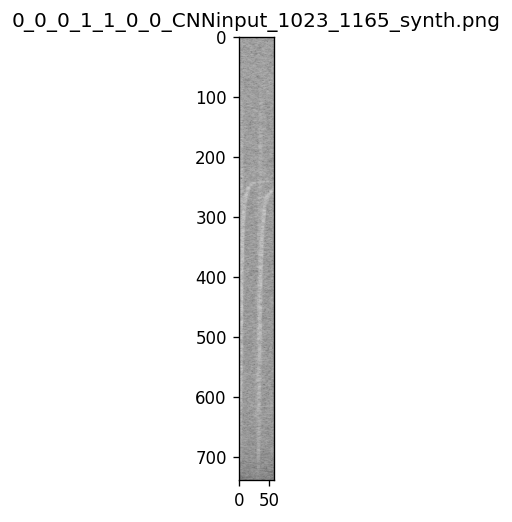

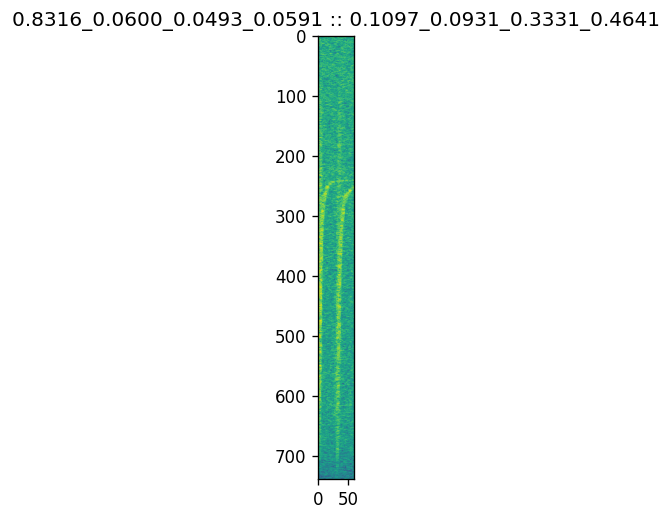

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


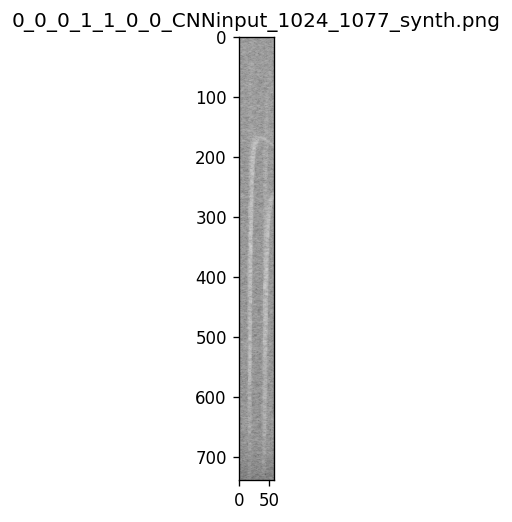

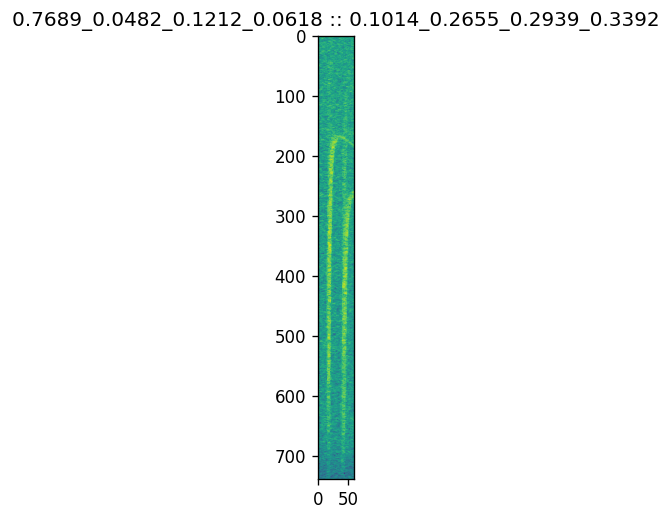

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


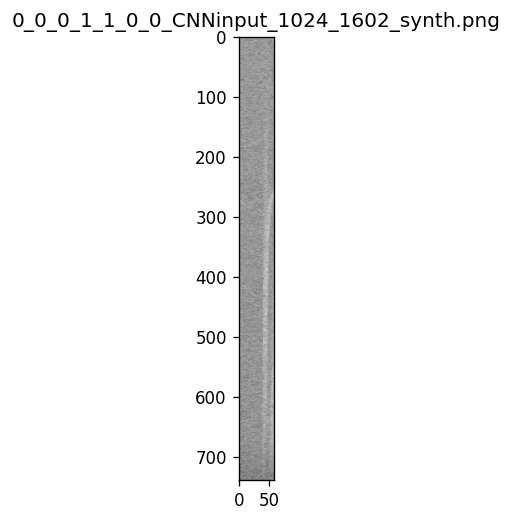

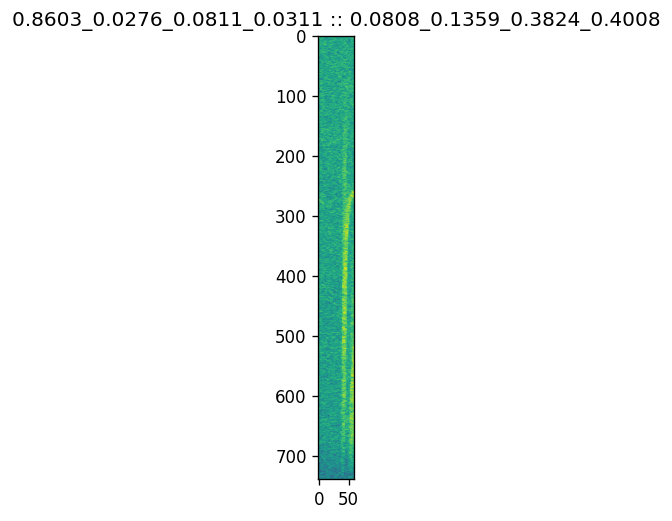

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


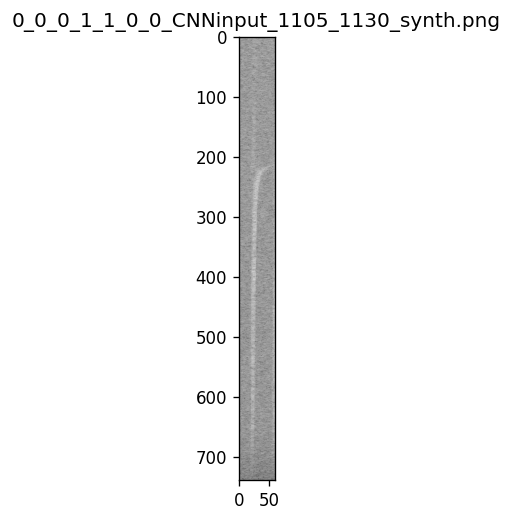

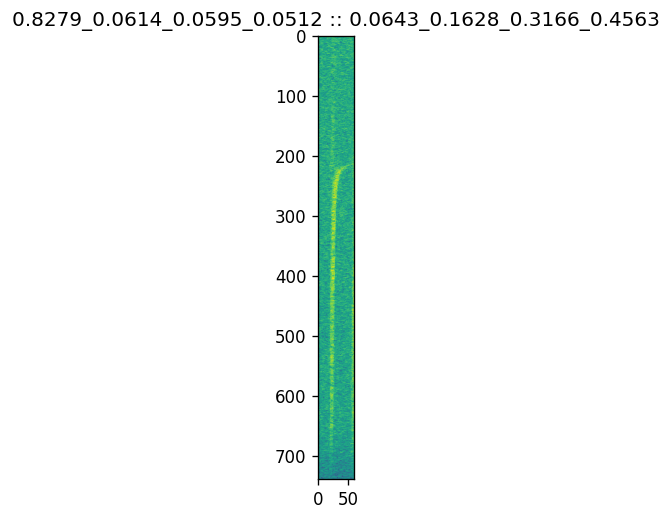

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


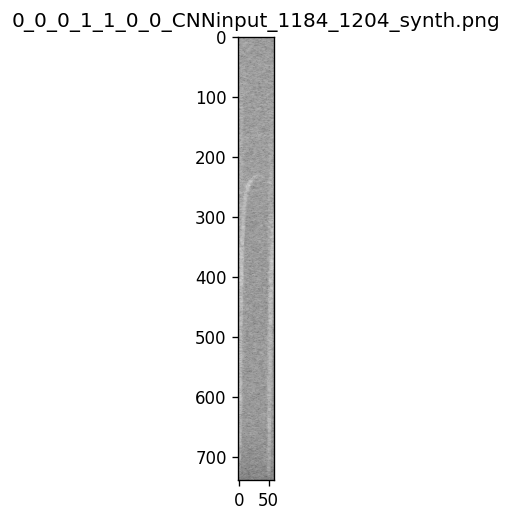

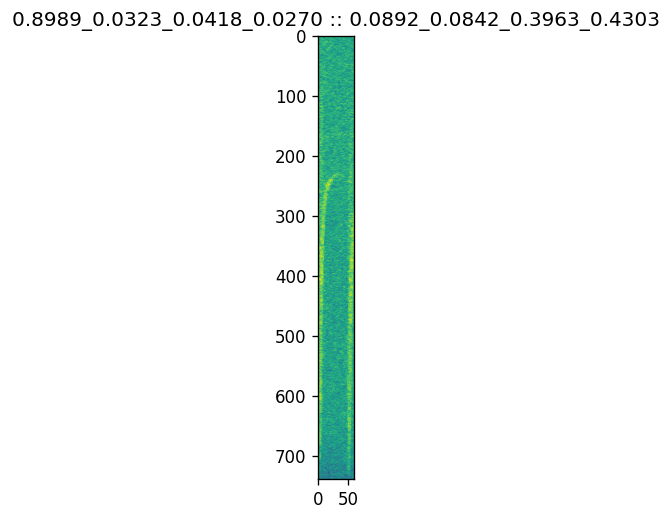

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


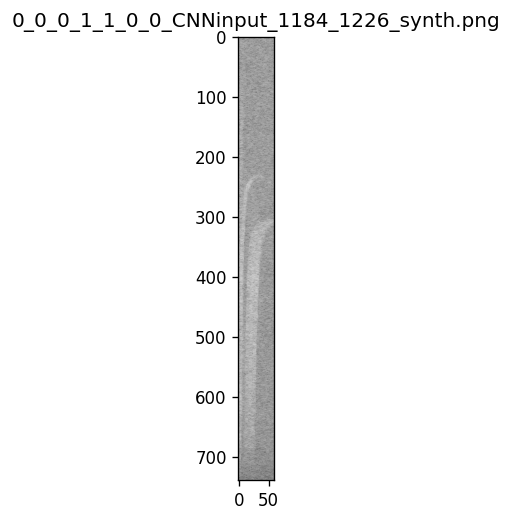

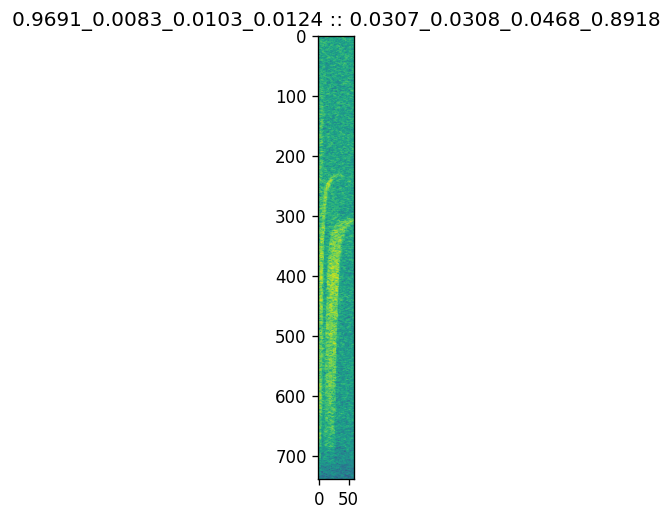

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


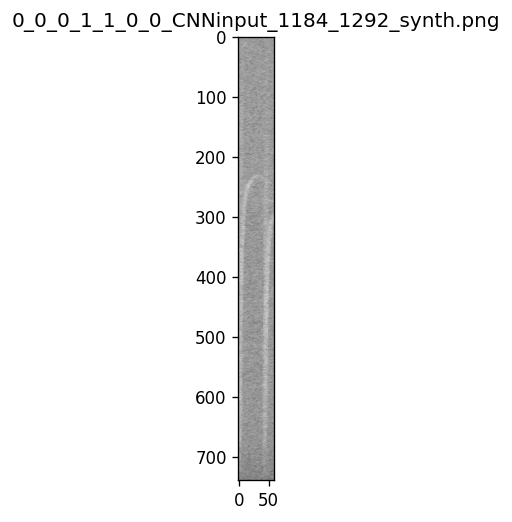

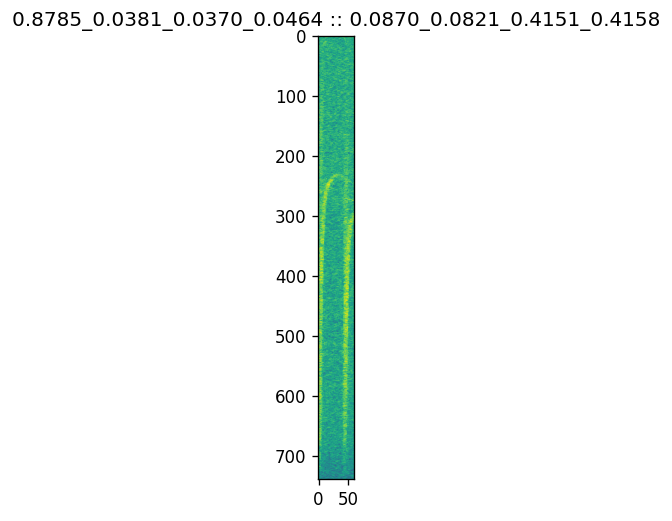

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


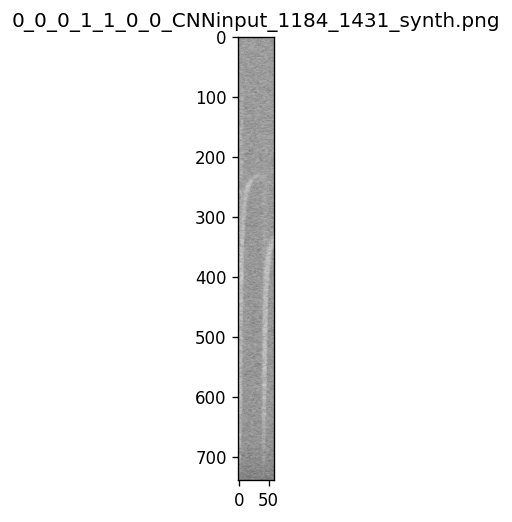

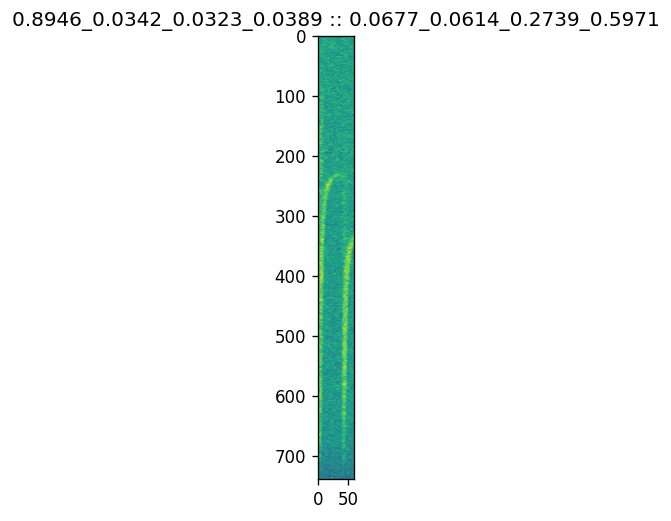

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


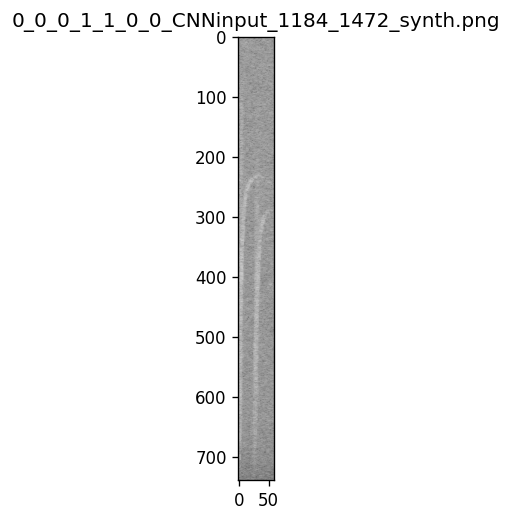

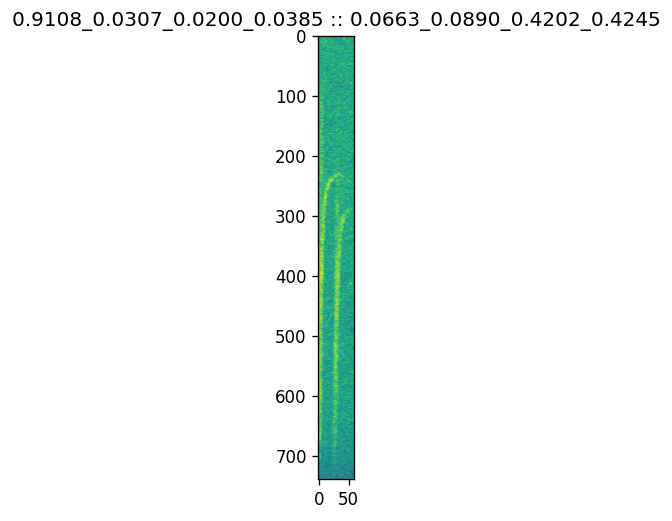

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


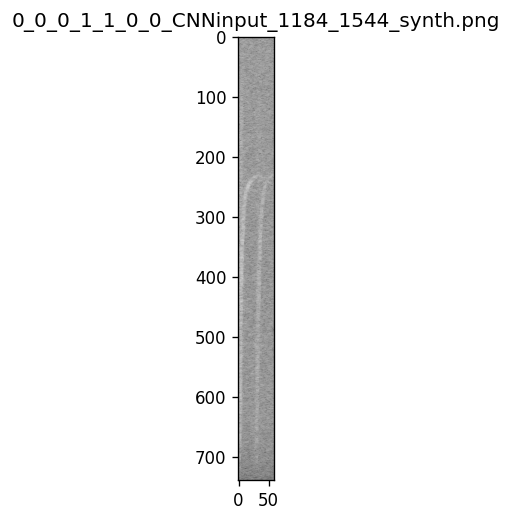

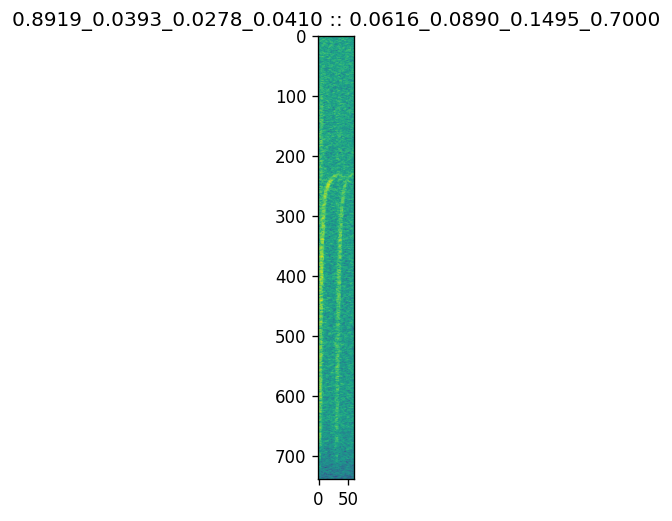

Labels:  [1. 0. 0. 0.] [0. 0. 1. 0.]
Predictions:  [1. 0. 0. 0.] [0. 0. 0. 1.]


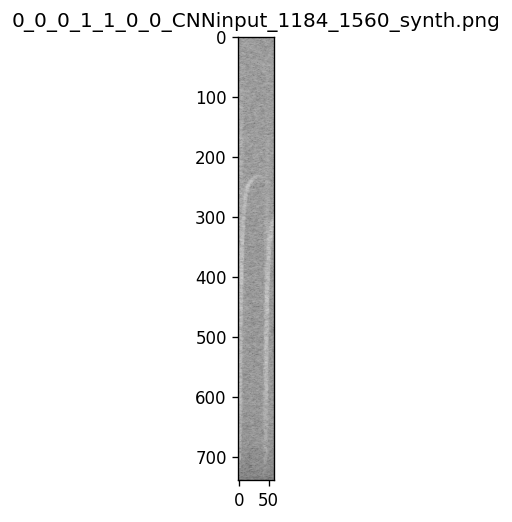

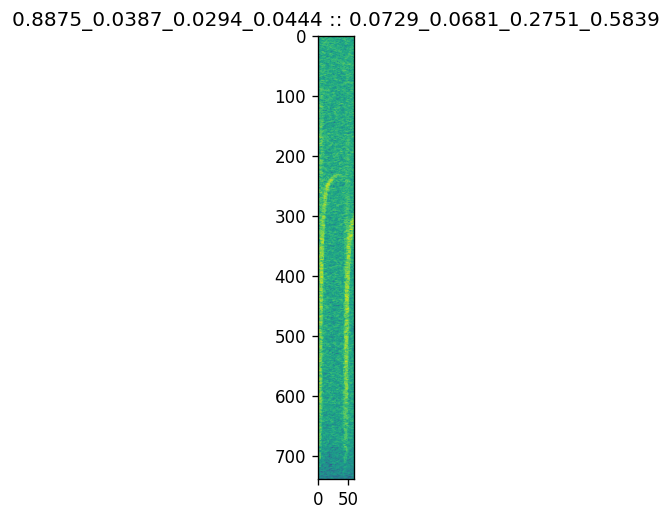

In [26]:
it1 = iter(ds_test_o)
it2 = iter(ds_test_names_o)

for i in np.arange(13):
    img, labels = next(it1)
    batch_names = next(it2)
    y1, y2 = labels
    b = y1.numpy().shape[0]
    predictions_test = model.predict(img)
    PlotDataset(y1,y2)
    for i in np.arange(b):
        p1, p2 = predictions_test
        current_name = batch_names[i].numpy().decode("UTF-8")
        current_img = cv2.imread(current_name, cv2.IMREAD_COLOR)
        current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB)

        z1 = np.zeros((4))
        predictions2_max_i = np.argmax(p1[i])
        z1[predictions2_max_i] = 1
        z2 = np.zeros((4))
        predictions2_max_i = np.argmax(p2[i])
        z2[predictions2_max_i] = 1
        
        if np.any(np.not_equal(y1[i], z1)) or np.any(np.not_equal(y2[i], z2)):
            print("Labels: ", np.array(y1[i]), np.array(y2[i]))
            print("Predictions: ", z1, z2)
            plotImage(current_img, title=os.path.basename(current_name))
            plotImage(img[i].numpy(), title=f"{predictionsToText(p1[i], sep='_')} :: {predictionsToText(p2[i], sep='_')}")
#         plotImage(img[i].numpy(), title=f"{p1[i]}_{p2[i]}_{p3[i]}_{p4[i]}_{p5[i]}_{p6[i]}")
#         plotImage(img[i].numpy(), title=f"{y1[i].numpy().astype(np.uint8)}_{y2[i].numpy().astype(np.uint8)}_{y3[i].numpy().astype(np.uint8)}_{y4[i].numpy().astype(np.uint8)}_{y5[i].numpy().astype(np.uint8)}_{y6[i].numpy().astype(np.uint8)}")